# Amazon Sentiment Analysis

This Jupyter Notebook provides a comprehensive analysis of customer sentiment based on Amazon reviews. Using natural language processing (NLP) techniques, we assess the sentiment of product reviews to uncover trends, patterns, and insights. The notebook follows a structured workflow, from data loading and cleaning to sentiment classification and visualization
_________________

<a name='contents'></a>

### Table of Contents 

##### A. [Import Packages](#section1)

##### B. [Load and Inspect Data](#section2)

##### C. [Clean and Prepare Data](#section3)

##### D. [Explore the Dataset](#section4)

##### E. [Perform Sentiment Analysis](#section5)

__________________________________________________________________

###### 📔 [return to contents](#contents)

<a id='section1'></a>
### 🔖 A. Import Packages 

In [1]:
# ============================
# 🔖[A] Import packages
# ============================
# pip install pandas nltk pyodbc sqlalchemy

# --------------------------
#  Basic & System Packages
# --------------------------
import os
import sys
import re

# ---------------------------------------
# Data Manipulation & Numerical Packages
# ---------------------------------------
import numpy as np
import pandas as pd

# --------------------------
# Database Packages
# --------------------------
import pyodbc

# --------------------------------------
# Natural Language Processing Packages
# --------------------------------------
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# Uncomment the following line if the VADER lexicon is not already downloaded:
# nltk.download('vader_lexicon')
from scipy.stats import pearsonr

# -----------------------------------
# Plotting & Visualization Packages
# -----------------------------------
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
import seaborn as sns
from IPython.display import display, HTML

###### 📔 [return to contents](#contents)

<a name='section2'></a>
### 🔖 B. Load and Inspect Data 

In [2]:
# ============================
# 🔖[B] Load and Inspect Data
# ============================
# upload df
df = pd.read_csv('amazon.csv')

# --
output_step ="\n"
output_step+="--------------------------------------------- \n"
output_step+="--> 📒(B.1) Contents of df under inspection : \n"
output_step+="--------------------------------------------- \n"
print(output_step)

print(df.head(2))

# --
output_step ="\n"
output_step+="----------------------------------------- \n"
output_step+="--> 📒(B.2) Info of df under inspection : \n"
output_step+="----------------------------------------- \n"
print(output_step)

print(df.info())

# --
output_step ="\n"
output_step+="--------------------------------------- \n"
output_step+="--> 📒(B.3) Shape df under inspection : \n"
output_step+="--------------------------------------- \n"
print(output_step)

print(df.shape)

# --
output_step ="\n"
output_step+="------------------------------------------------ \n"
output_step+="--> 📒(B.4) Most entries & most unique entries : \n"
output_step+="------------------------------------------------ \n"
print(output_step)

count_df = pd.DataFrame({
    'Total_Count': df.count(),
    'Unique_Count': df.nunique()
})
# Sort by Unique Count in descending order
count_df = count_df.sort_values(by="Unique_Count", ascending=False)
print(count_df)

# --
output_step ="\n"
output_step+="--------------------------------------- \n"
output_step+="--> 📒(B.5) Duplicate rows identified : \n"
output_step+="--------------------------------------- \n"
print(output_step)

duplicate = df[df.duplicated()]
print(duplicate)

# -//-//-//-//-//-//-//-//-
# --> Duplicates found?
# -//-//-//-//-//-//-//-//-

# To DROP duplicates based on specific columns:
# df.drop_duplicates(subset=['A'], keep='first')  # Drops based on column 'A'

# To DROP duplicates in place:
# df.drop_duplicates(inplace=True)

# --
output_step ="\n"
output_step+="---------------------------- \n"
output_step+="--> 📒(B.6) NaN identified : \n"
output_step+="---------------------------- \n"
print(output_step)
print(df.isna().sum())

# -//-//-//-//-//-//-//-//-
# --> Nan found?
# -//-//-//-//-//-//-//-//-

# To DROP rows where either column "A" or "B" has NaN
# df_no_nan_AB = df.dropna(subset=['A', 'B'])

# To DROP rows where any column has NaN
# df_no_nan_AB = df.dropna()

# To REPLACE NaN in column 'A' with the column's average
# df['A'] = df['A'].fillna(df['A'].mean())

# To REPLACE NaN in all numeric columns with their mean:
# df.fillna(df.mean(), inplace=True)


--------------------------------------------- 
--> 📒(B.1) Contents of df under inspection : 
--------------------------------------------- 

   product_id                                       product_name  \
0  B07JW9H4J1  Wayona Nylon Braided USB to Lightning Fast Cha...   
1  B098NS6PVG  Ambrane Unbreakable 60W / 3A Fast Charging 1.5...   

                                            category discounted_price  \
0  Computers&Accessories|Accessories&Peripherals|...             ₹399   
1  Computers&Accessories|Accessories&Peripherals|...             ₹199   

  actual_price discount_percentage rating rating_count  \
0       ₹1,099                 64%    4.2       24,269   
1         ₹349                 43%    4.0       43,994   

                                       about_product  \
0  High Compatibility : Compatible With iPhone 12...   
1  Compatible with all Type C enabled devices, be...   

                                             user_id  \
0  AG3D6O4STAQKAY2UVGEUV46KN35Q,A

In [3]:
# -//-//-//-//-//-//-//-//-//-
# --> 🔎 Notable observations
# -//-//-//-//-//-//-//-//-//-

# - actual_price and discounted_price columns are in object type, convert to to float type
# - rating column can be inspected for non-numeric data, then converted to float or integer type
# - given that only one rating_content is shown for each product_name, we are assuming that is the mean consensus among all the ratings as numbered by rating_count

###### 📔 [return to contents](#contents)

<a name='section3'></a>
### 🔖 C. Clean and Prepare Data 

In [4]:
# ==============================
# 🔖[C] Clean and Prpepare Data
# ==============================

# ---------------------------------------------------------------------------------------------
# --> 📒[C.1] Cleaning price columns (remove percent symbol, convert object type to int type :
# --------------------------------------------------------------------------------------------- 
df_fixed = df.copy()
df_fixed['discounted_price_conv'] = (
    df_fixed['discounted_price']
    .str.replace(r'[₹$€£,]', '', regex=True)  # remove currency symbols and commas
    .astype(float)
    .round(3)
)

df_fixed['actual_price_conv'] = (
    df_fixed['actual_price']
    .str.replace(r'[₹$€£,]', '', regex=True)  # remove currency symbols and commas
    .astype(float)
    .round(3)
)


df_fixed['discount_percentage_conv'] = (
    df_fixed['discount_percentage']
    .str.replace(r'[%]', '', regex=True)  # remove currency symbols and commas
    .astype(int))


print(df_fixed[['discounted_price_conv','actual_price_conv','discount_percentage_conv']].head(5))

   discounted_price_conv  actual_price_conv  discount_percentage_conv
0                  399.0             1099.0                        64
1                  199.0              349.0                        43
2                  199.0             1899.0                        90
3                  329.0              699.0                        53
4                  154.0              399.0                        61


In [5]:
# ------------------------------------
# --> 📒[C.2] Inpsect rating column : 
# ------------------------------------
print(df_fixed['rating'].unique())

['4.2' '4.0' '3.9' '4.1' '4.3' '4.4' '4.5' '3.7' '3.3' '3.6' '3.4' '3.8'
 '3.5' '4.6' '3.2' '5.0' '4.7' '3.0' '2.8' '4' '3.1' '4.8' '2.3' '|' '2'
 '3' '2.6' '2.9']


In [6]:
# ------------------------------------------------------------------------------------------------ 
# --> 📒[C.3] Clean rating column (remove non-numeric values, convert object type to float type :
# ------------------------------------------------------------------------------------------------
df_fixed = df_fixed[df_fixed['rating'] != '|']

# reset index after filtering 
df_fixed = df_fixed.reset_index(drop=True)

print(df_fixed['rating'].unique())

# convert to float type
df_fixed['rating'] = df_fixed['rating'].astype(float).round(1)
print(df_fixed['rating'].unique())

print(' ')
print(df_fixed['rating'].dtype)

['4.2' '4.0' '3.9' '4.1' '4.3' '4.4' '4.5' '3.7' '3.3' '3.6' '3.4' '3.8'
 '3.5' '4.6' '3.2' '5.0' '4.7' '3.0' '2.8' '4' '3.1' '4.8' '2.3' '2' '3'
 '2.6' '2.9']
[4.2 4.  3.9 4.1 4.3 4.4 4.5 3.7 3.3 3.6 3.4 3.8 3.5 4.6 3.2 5.  4.7 3.
 2.8 3.1 4.8 2.3 2.  2.6 2.9]
 
float64


In [7]:
# ------------------------------------------------------------------------------------------------------------- 
# --> 📒[C.3] Clean rating_count column (drop NaN, remove comma symbol, convert object type to integer type) :
# -------------------------------------------------------------------------------------------------------------
df_fixed = df_fixed.dropna()

df_fixed['rating_count_conv'] = (
    df_fixed['rating_count']
    .str.replace(r'[,]', '', regex=True)  # remove currency symbols and commas
    .astype(int))

print(df_fixed['rating_count_conv'])

0       24269
1       43994
2        7928
3       94363
4       16905
        ...  
1459     1090
1460     4118
1461      468
1462     8031
1463     6987
Name: rating_count_conv, Length: 1462, dtype: int64


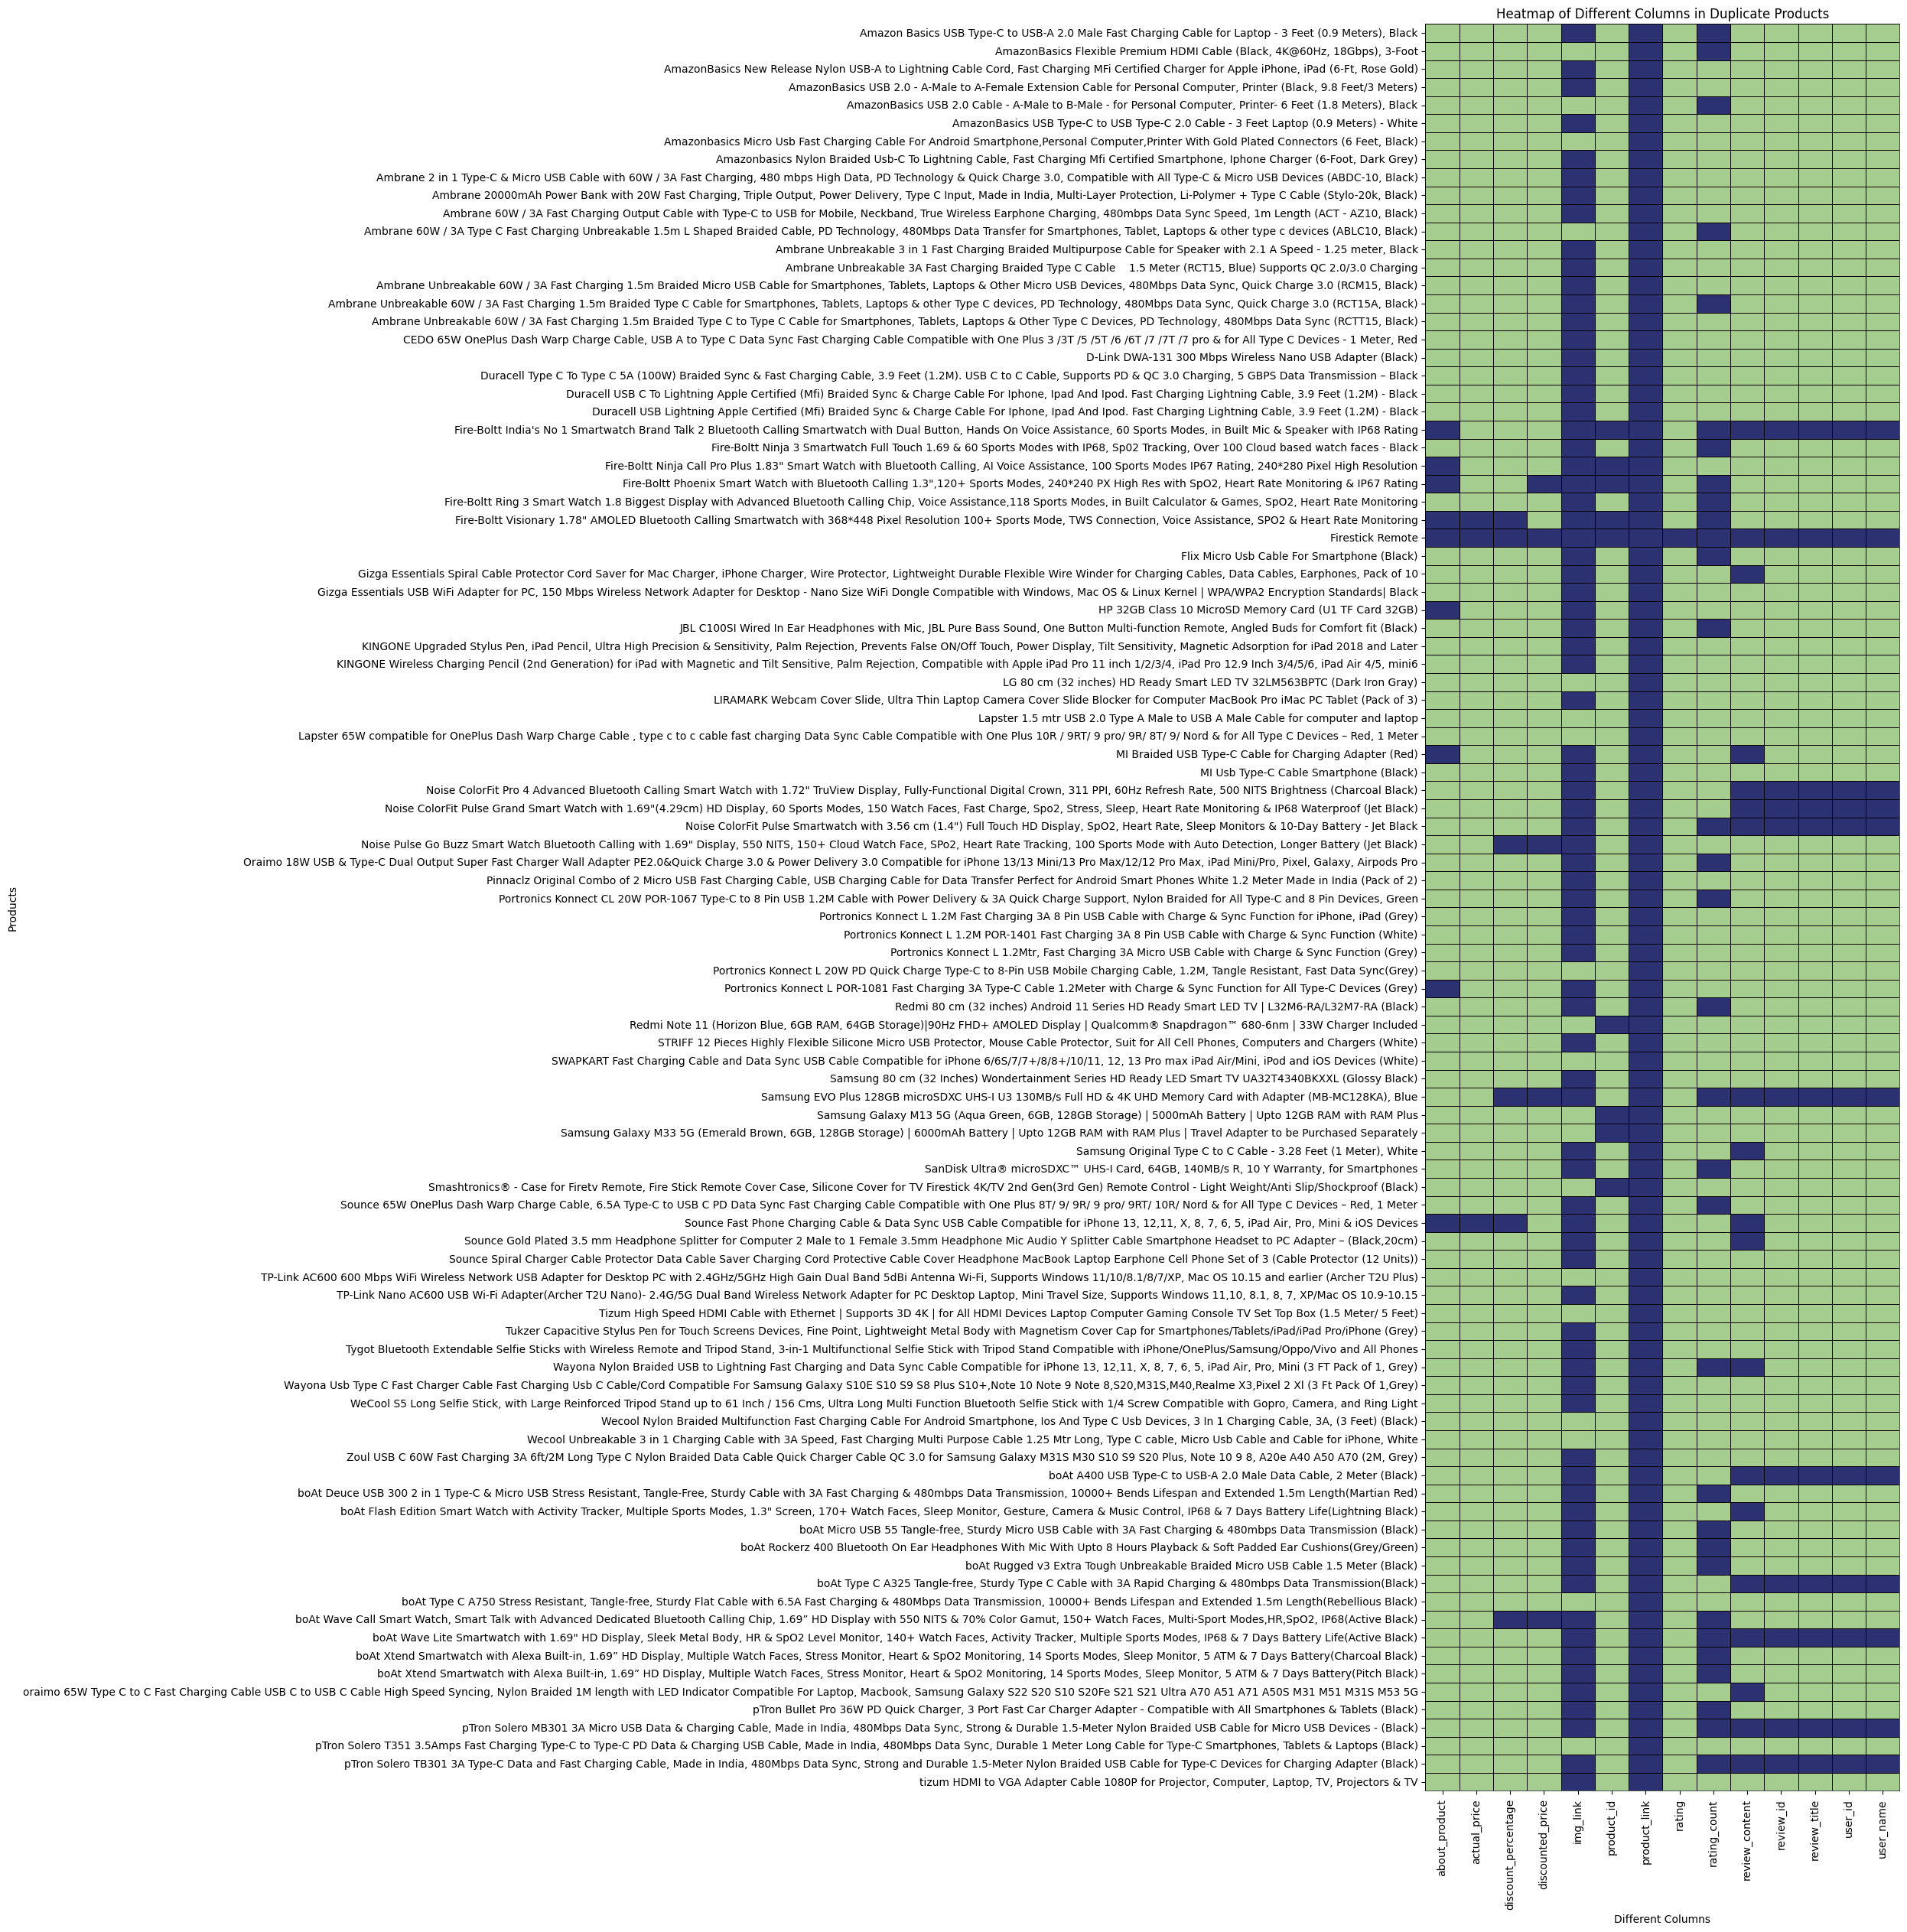

In [8]:
# ------------------------------------------------------------- 
# --> 📒[C.4] Inspect product_name column (duplicates found) :
# -------------------------------------------------------------

# Find duplicates based on 'product_name'
duplicate_check = df.duplicated(subset=['product_name'], keep=False)
duplicates_df = df[duplicate_check]

# Identify columns with differences among duplicates
different_columns = {}
for product in duplicates_df['product_name'].unique():
    subset = duplicates_df[duplicates_df['product_name'] == product]
    varying_cols = subset.nunique()[subset.nunique() > 1].index.tolist()
    if varying_cols:
        different_columns[product] = varying_cols

# Convert dictionary to DataFrame for visualization
products = []
columns = []
for product, cols in different_columns.items():
    for col in cols:
        products.append(product)
        columns.append(col)

df_diff = pd.DataFrame({'Product': products, 'Column': columns})

# Pivoting to create a binary heatmap format (1 where differences exist, else 0)
df_pivot = df_diff.pivot_table(index='Product', columns='Column', aggfunc=lambda x: 1, fill_value=0)

plt.figure(figsize=(8, 30))
ax = sns.heatmap(df_pivot, cmap="crest", linecolor='black', linewidths=0.5, cbar=False)

plt.xlabel("Different Columns")
plt.ylabel("Products")
plt.title("Heatmap of Different Columns in Duplicate Products")

# First, try ensuring the spines are visible
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_edgecolor('black')
    spine.set_linewidth(0.5)

# Add a rectangle patch around the entire heatmap box
rect = patches.Rectangle((0, 0), 1, 1, transform=ax.transAxes, 
                         fill=False, edgecolor='black', linewidth=0.5)
ax.add_patch(rect)

plt.show()

In [9]:
# -//-//-//-//-//-//-//-//-//-//-//-//-//-//-
# --> 🔎 Manual search of products in heatmap
# -//-//-//-//-//-//-//-//-//-//-//-//-//-//-

# Define the search text
search_text = 'Noise Pulse Go Buzz Smart Watch'

# Filter rows where 'product_name' contains the given text (case-insensitive)
matching_rows = df[df['product_name'].str.contains(search_text, case=False, na=False)]

# List of columns you want to print
desired_columns = [
    'product_id', 
    'product_name', 
    'discounted_price',
    'actual_price', 
    'discount_percentage', 
    'rating', 
    'rating_count',
    'user_name', 
    'img_link', 
    'product_link']

if not matching_rows.empty:
    # Identify columns with differences (if needed)
    differing_columns = matching_rows.nunique()[matching_rows.nunique() > 1].index.tolist()
    print("\nColumns that differ among matching rows:")
    print(differing_columns)
    
    # Display only the desired columns from the matching rows
    display(matching_rows[desired_columns])
else:
    print("No matching rows found.")


Columns that differ among matching rows:
['discounted_price', 'discount_percentage', 'img_link', 'product_link']


product_id                                       product_name  \
344  B0B5LVS732  Noise Pulse Go Buzz Smart Watch Bluetooth Call...   
594  B0B5LVS732  Noise Pulse Go Buzz Smart Watch Bluetooth Call...   

    discounted_price actual_price discount_percentage rating rating_count  \
344           ₹1,898       ₹4,999                 62%    4.1       10,689   
594           ₹1,999       ₹4,999                 60%    4.1       10,689   

                                             user_name  \
344  Sumit Nath,Aneesh Mohan,Yogesh Badekar,Manisha...   
594  Sumit Nath,Aneesh Mohan,Yogesh Badekar,Manisha...   

                                              img_link  \
344  https://m.media-amazon.com/images/I/41Peg4pz7f...   
594  https://m.media-amazon.com/images/W/WEBP_40237...   

                                          product_link  
344  https://www.amazon.in/Noise-Bluetooth-Calling-...  
594  https://www.amazon.in/Noise-Bluetooth-Calling-...

In [10]:
# -//-//-//-//-//-//-//-//-//-//-//-//-//-//-//-
# --> 🔎 Observations on product_name duplicates
# -//-//-//-//-//-//-//-//-//-//-//-//-//-//-//-
#
# 1. Additional review recorded:
#    - Duplicate entries may display a different review count, indicating an additional review has been recorded.
#
# 2. Different product_link and img_link:
#    - Example: "Amazon Basics USB Type-C"
#    - Occurs because the website assigns different categories (e.g., "Computers & Accessories" vs. "Electrical"),
#      even though the product category remains consistent across duplicated entries.
#
# 3. Differences in actual price:
#    - Example: "Source Fast Phone Charging Cable & Data" shows an Actual Price of 1999 in one instance and 999 in another,
#      despite both entries having a discounted price of 199.
#
# 4. Variations in the about_product description:
#    - Example: For "Source Fast Phone Charging":
#         - One entry includes a detailed description with:
#              【Fast Charger & Data Sync】
#              【Compatibility】
#              【Sturdy & Durable】
#              【Ultra High Quality】
#              【Good After Sales Service】
#         - Another entry omits the 【Compatibility】 detail.
#
# 5. Discounted price variations:
#    - Example: For "Noise Pulse Go Buzz Smart Watch":
#         - One entry shows a discounted price of 1898 while another shows 1999 (a difference of 100 rupees),
#           despite having the same user_id, rating, and review_count, indicating they refer to the same product.

# Proposed Solution:
# - For duplicates, retain the entry with the highest review_count to ensure the most updated data is kept.
# - For duplicates with the same product_name and review_count but different discounted prices, calculate the mean of the discounted prices.


In [11]:
# ---------------------------------------------------------- 
# --> 📒[C.5] Clean product_name column (duplicates removed) :
# ----------------------------------------------------------

# Count duplicates before applying the deduplication function
total_rows_before = len(df_fixed)
duplicates_before = df_fixed.duplicated(subset=['product_name']).sum()
unique_products_before = df_fixed['product_name'].nunique()

print("Before deduplication:")
print(f"  Total rows: {total_rows_before}")
print(f"  Unique product_name entries: {unique_products_before}")
print(f"  Duplicate rows (by product_name): {duplicates_before}")

# Deduplication function as provided
def resolve_duplicates(group):
    # Find the maximum rating_count within the group
    max_rating = group['rating_count'].max()
    # Filter to rows with this maximum rating_count
    group_max = group[group['rating_count'] == max_rating]
    
    # If only one row has the highest rating_count, return that row as-is.
    if len(group_max) == 1:
        return group_max
    else:
        # For multiple rows with equal highest rating_count,
        # create a combined row:
        combined = group_max.iloc[0].copy()
        # Calculate the mean discounted_price_conv
        combined['discounted_price_conv'] = group_max['discounted_price_conv'].mean()
        # (Other columns remain as in the first row; adjust as needed.)
        return combined.to_frame().T

# Apply the deduplication function by grouping by product_name
df_fixed = df_fixed.groupby('product_name', group_keys=False).apply(resolve_duplicates).reset_index(drop=True)

# Count duplicates after applying the deduplication function
total_rows_after = len(df_fixed)
duplicates_after = df_fixed.duplicated(subset=['product_name']).sum()
unique_products_after = df_fixed['product_name'].nunique()

print("\nAfter deduplication:")
print(f"  Total rows: {total_rows_after}")
print(f"  Unique product_name entries: {unique_products_after}")
print(f"  Duplicate rows (by product_name): {duplicates_after}")


Before deduplication:
  Total rows: 1462
  Unique product_name entries: 1334
  Duplicate rows (by product_name): 128

After deduplication:
  Total rows: 1334
  Unique product_name entries: 1334
  Duplicate rows (by product_name): 0


In [12]:
# -----------------------------------------------------------
# --> 📒[C.6] Organize category column (add space and splice) :
# -----------------------------------------------------------

# Helper function to clean each category token
def clean_category_token(token):
    # Add space before and after '&'
    token = re.sub(r"\s*&\s*", " & ", token)
    # Ensure USB, LAN, PC, DVI, SATA, AV, HDMI, and RC have a preceding and trailing space
    token = re.sub(r"(?<!\s)(USB)(?!\s)", r" \1 ", token)
    token = re.sub(r"(?<!\s)(LAN)(?!\s)", r" \1 ", token)
    token = re.sub(r"(?<!\s)(PC)(?!\s)", r" \1 ", token)
    token = re.sub(r"(?<!\s)(DVI)(?!\s)", r" \1 ", token)
    token = re.sub(r"(?<!\s)(SATA)(?!\s)", r" \1 ", token)
    token = re.sub(r"(?<!\s)(AV)(?!\s)", r" \1 ", token)
    token = re.sub(r"(?<!\s)(HDMI)(?!\s)", r" \1 ", token)
    token = re.sub(r"(?<!\s)(RCA)(?!\s)", r" \1 ", token)
    token = re.sub(r"(?<!\s)(OTG)(?!\s)", r" \1 ", token)
    token = re.sub(r"(?<!\s)(HEPA)(?!\s)", r" \1 ", token)
    # Insert a space between a lowercase letter and an uppercase letter
    token = re.sub(r"(?<=[a-z])(?=[A-Z])", " ", token)
    # Add a space after commas if not already present
    token = re.sub(r",(?=\S)", ", ", token)
    # Clean up extra spaces
    token = re.sub(r"\s+", " ", token).strip()
    return token

# Function to organize the category column into levels
def organize_category(row):
    cat_str = row['category']
    # Split the original string by '|'
    tokens = cat_str.split("|")
    # Clean each token
    cleaned_tokens = [clean_category_token(token) for token in tokens]
    
    # Level 1: First token only
    level1 = cleaned_tokens[0] if cleaned_tokens else ""
    
    # Level 2: Join first two tokens, if available
    level2 = " | ".join(cleaned_tokens[:2]) if len(cleaned_tokens) >= 2 else level1
    
    # Level 3: If more than 2 tokens, show first two, then ellipsis, then last token;
    # otherwise, just show level2.
    if len(cleaned_tokens) > 2:
        level3 = " | ".join([cleaned_tokens[0], cleaned_tokens[1]]) + " ... | " + cleaned_tokens[-1]
    else:
        level3 = level2
    
    return pd.Series({
        'category_level1': level1,
        'category_level2': level2,
        'category_level3': level3
    })

# Apply the function row-wise to create the new category level columns
df_fixed[['category_level1', 'category_level2', 'category_level3']] = df_fixed.apply(organize_category, axis=1)

# Group by category_level1, aggregate the first category_level2 and category_level3 values and count records
grouped = df_fixed.groupby('category').agg({
    'category_level1': 'first',
    'category_level2': 'first',
    'category_level3': 'first',
    'product_name': 'count'
}).reset_index().rename(columns={'product_name': 'Count'})

# Display the grouped data as an HTML table
display(HTML(grouped.head(5).to_html(index=False)))

In [13]:
# ------------------------------------------------------
# --> 📒[C.7] Organize product column (truncate content) :
# ------------------------------------------------------

# Create the new product_name_trunc column (if not already created)
def truncate_product_name(name, limit=60):
    if len(name) > limit:
        return name[:30] + "..." + name[-30:]
    else:
        return name

df_fixed['product_name_trunc'] = df_fixed['product_name'].apply(truncate_product_name)

# Display the product_name_trunc column as an HTML table
display(HTML(df_fixed[['product_name','product_name_trunc']].head(5).to_html(index=False)))

###### 📔 [return to contents](#contents)

<a name='section4'></a>
### 🔖 D. Explore the Dataset 

Plot saved to /mnt/c/Users/Joseph/Desktop/quick/0_data/Personal/amazon/fig/category_main_count.png


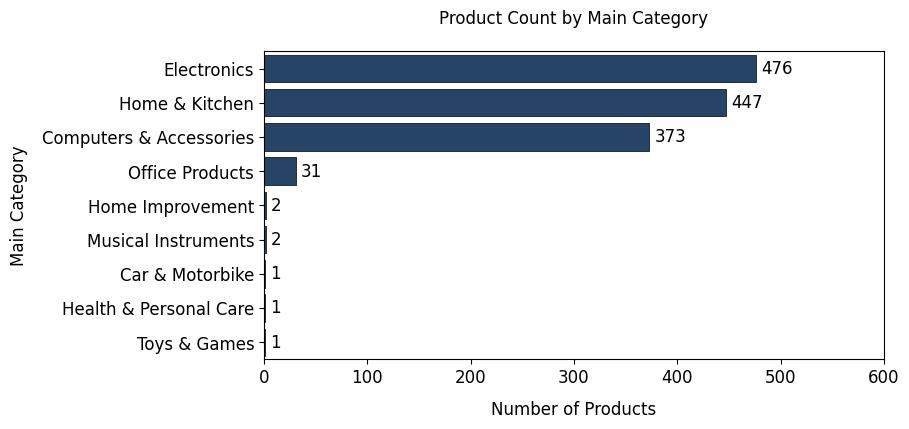

Total Number of Products
1334


In [14]:
# ===============================
# 🔖[D] Explore the Dataset
# ===============================

# -------------------------------------------------------
# --> 📒[D.1] Number of unique products per main category :
# -------------------------------------------------------

# -------------------------------
# Aggregate Data by Main Category
# --------------------------------
df_aggregated_main = df_fixed.groupby('category_level1').agg(
    count=('category_level1', 'size')).reset_index()

# For the count plot we sort by count (number of products)
df_aggregated_main = df_aggregated_main.sort_values(by='count', ascending=False)

# -----------------------------
# Plotting Function for Count by Main Category
# -----------------------------
def plot_count_by_category(df, title, save_file=None, save_directory=None):
    plt.figure(figsize=(8, 4))
    # Plot a horizontal barplot: x = count, y = main category; all bars in rainbow indigo (#1C436F)
    ax = sns.barplot(data=df, x='count', y='category_level1', color='#1C436F')
    
    # Set x-axis maximum to 600
    plt.xlim(0, 600)
    
    # Annotate each bar with its count (offset increased to 5 units)
    offset = 5
    for bar in ax.patches:
        bar.set_edgecolor("black")
        bar.set_linewidth(0.5)
        width = bar.get_width()
        y = bar.get_y() + bar.get_height() / 2
        ax.text(width + offset, y, f'{int(width)}', va='center', ha='left', fontsize=12, color='black')
    
    plt.xlabel("Number of Products", fontsize=12, labelpad=10)
    plt.ylabel("Main Category", fontsize=12, labelpad=10)
    plt.title(title, fontsize=12, pad=20)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    if save_file:
        if save_directory:
            os.makedirs(save_directory, exist_ok=True)
            filepath = os.path.join(save_directory, save_file)
        else:
            filepath = save_file
        plt.savefig(filepath, bbox_inches='tight')
        print(f"Plot saved to {filepath}")
    
    plt.show()

# -----------------------------
# Display the Count Plot
# -----------------------------
plot_count_by_category(
    df_aggregated_main,
    "Product Count by Main Category",
    save_file="category_main_count.png",
    save_directory="/mnt/c/Users/Joseph/Desktop/quick/0_data/Personal/amazon/fig/"
)

print('Total Number of Products')
print(df_fixed['product_name'].count())

###### 📔 [return to contents](#contents)

<a name='section5'></a>
### 🔖 E. Perform Sentiment Analysis 

In [15]:
# ===============================
# 🔖[E] Perform Sentiment Analysis 
# ===============================

# ----------------------------------------------------------------------------------
# --> 📒[E.1] Determine sentiment score, sentiment category, and sentiment bucket :
# ---------------------------------------------------------------------------------- 

# Initialize the VADER sentiment intensity analyzer for analyzing the sentiment of text data
sia = SentimentIntensityAnalyzer()

# Define a function to calculate sentiment scores using VADER
def calculate_sentiment(review):
    # Get the sentiment scores for the review text
    sentiment = sia.polarity_scores(review)
    # Return the compound score, which is a normalized score between -1 (most negative) and 1 (most positive)
    return sentiment['compound']

# Define a function to categorize sentiment using both the sentiment score and the review rating
def categorize_sentiment(score, rating):
    # Use both the text sentiment score and the numerical rating to determine sentiment category
    if score > 0.05:  # Positive sentiment score
        if rating >= 4.0:
            return 'Positive'  # High rating and positive sentiment
        elif 3.0 <= rating < 4.0:
            return 'Mixed Positive'  # Neutral rating but positive sentiment
        else:
            return 'Mixed Negative'  # Low rating but positive sentiment
    elif score < -0.05:  # Negative sentiment score
        if rating <= 2.0:
            return 'Negative'  # Low rating and negative sentiment
        elif 3.0 <= rating < 4.0:
            return 'Mixed Negative'  # Neutral rating but negative sentiment
        else:
            return 'Mixed Positive'  # High rating but negative sentiment
    else:  # Neutral sentiment score
        if rating >= 4.0:
            return 'Positive'  # High rating with neutral sentiment
        elif rating <= 2.0:
            return 'Negative'  # Low rating with neutral sentiment
        else:
            return 'Neutral'  # Neutral rating and neutral sentiment

# Define a function to bucket sentiment scores into text ranges
def sentiment_bucket(score):
    if score >= 0.5:
        return '0.5 to 1.0'  # Strongly positive sentiment
    elif 0.0 <= score < 0.5:
        return '0.0 to 0.49'  # Mildly positive sentiment
    elif -0.5 <= score < 0.0:
        return '-0.49 to 0.0'  # Mildly negative sentiment
    else:
        return '-1.0 to -0.5'  # Strongly negative sentiment

# Apply sentiment analysis to calculate sentiment scores for each review
df_fixed['SentimentScore'] = df_fixed['review_content'].apply(calculate_sentiment)

# Apply sentiment categorization using both text and rating
df_fixed['SentimentCategory'] = df_fixed.apply(
    lambda row: categorize_sentiment(row['SentimentScore'], row['rating']), axis=1)

# Apply sentiment bucketing to categorize scores into defined ranges
df_fixed['SentimentBucket'] = df_fixed['SentimentScore'].apply(sentiment_bucket)

# Display the first few rows of the DataFrame with sentiment scores, categories, and buckets
print(df_fixed.head())

# Save the DataFrame with sentiment scores, categories, and buckets to a new CSV file 
#customer_reviews_df.to_csv(r'C:\Users\Joseph\Documents\fact_customer_reviews_with_sentiment_new.csv', index=False)

   product_id                                       product_name  \
0  B0BMTZ4T1D  !!1000 Watt/2000-Watt Room Heater!! Fan Heater...   
1  B0BMZ6SY89  !!HANEUL!!1000 Watt/2000-Watt Room Heater!! Fa...   
2  B09RFB2SJQ  10WeRun Id-116 Bluetooth Smartwatch Wireless F...   
3  B08TGG316Z  10k 8k 4k HDMI Cable, Certified 48Gbps 1ms Ult...   
4  B00N1U7JXM  3M Post-it Sticky Note Cube, 200 Sheets (4 Col...   

                                            category discounted_price  \
0  Home&Kitchen|Heating,Cooling&AirQuality|RoomHe...             ₹784   
1  Home&Kitchen|Heating,Cooling&AirQuality|RoomHe...             ₹899   
2        Electronics|WearableTechnology|SmartWatches             ₹499   
3  Electronics|HomeTheater,TV&Video|Accessories|C...             ₹999   
4  OfficeProducts|OfficePaperProducts|Paper|Stati...              ₹90   

  actual_price discount_percentage rating rating_count  \
0       ₹1,599                 51%    4.5           11   
1       ₹1,599                 44%  

/tmp/ipykernel_1775/1570880941.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


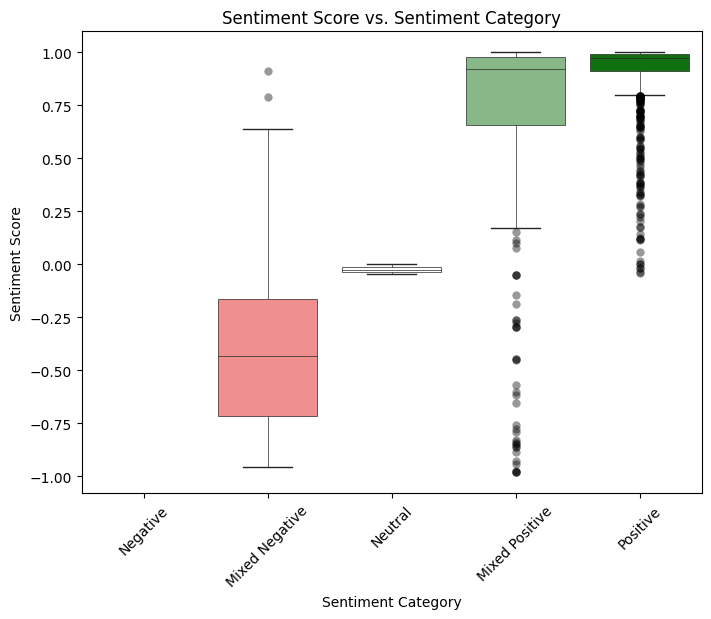

In [16]:
# ---------------------------------------------------------------
# --> 📒[E.2] Inspect accuracy of sentiment category and score :
# ---------------------------------------------------------------

# Define the order from right to left
sentiment_order = ['Negative', 'Mixed Negative', 'Neutral', 'Mixed Positive', 'Positive']

# Convert SentimentCategory to categorical with reversed order
df_fixed['SentimentCategory'] = pd.Categorical(df_fixed['SentimentCategory'], categories=sentiment_order, ordered=True)

# Create a red-white-green colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_rwg", ["red", "white", "green"], N=len(sentiment_order))

# Generate colors from this custom colormap
custom_palette = [custom_cmap(i / (len(sentiment_order) - 1)) for i in range(len(sentiment_order))]

# Generate seaborn plot
plt.figure(figsize=(8, 6))
ax = sns.boxplot(
    x='SentimentCategory', 
    y='SentimentScore', 
    data=df_fixed, 
    palette=custom_palette, 
    order=sentiment_order, 
    showcaps=True, 
    whiskerprops={'linewidth': .5},
    boxprops={'linewidth': .5},
    medianprops={'linewidth': .5},
    flierprops={'marker': 'o', 'markerfacecolor': 'black', 'alpha': 0.4, 'markersize': 6, 'markeredgewidth': 0}
)

plt.xlabel("Sentiment Category")
plt.ylabel("Sentiment Score")
plt.title("Sentiment Score vs. Sentiment Category")
plt.xticks(rotation=45)

# Define directory and filename
save_dir = "/mnt/c/Users/Joseph/Desktop/quick/0_data/Personal/amazon/fig"
file_name = "fig_relation_sentiment_score_category.png"

# Ensure the directory exists
os.makedirs(save_dir, exist_ok=True)  # Creates the directory if it doesn't exist

# Full file path
save_path = os.path.join(save_dir, file_name)

# Save the figure
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()


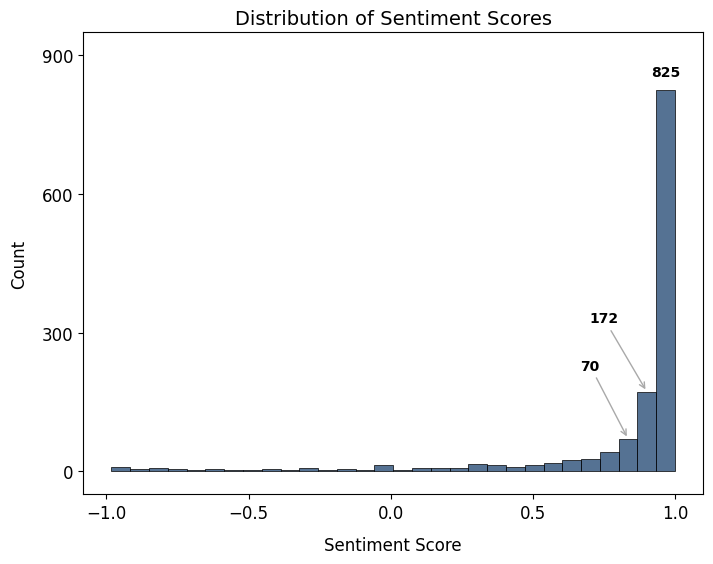

Figure saved to: /mnt/c/Users/Joseph/Desktop/quick/0_data/Personal/amazon/fig/fig_distribution_sentiment_score.png
count    1334.000000
mean        0.813055
std         0.376824
min        -0.982100
25%         0.862050
50%         0.960100
75%         0.988300
max         0.999900
Name: SentimentScore, dtype: float64


In [17]:
# -----------------------------------------------------
# --> 📒[E.3] Output distribution of sentiment score :
# -----------------------------------------------------

# Sentiment Score Plot
plt.figure(figsize=(8, 6))
ax = sns.histplot(
    df_fixed['SentimentScore'], 
    bins=30, 
    color="#1C436F", 
    edgecolor="black",  # Ensure bars have black outlines
    linewidth=0.5
)

# Set axis labels and title with padding offsets
plt.xlabel("Sentiment Score", fontsize=12, labelpad=10)  # Added label padding for X-axis
plt.ylabel("Count", fontsize=12, labelpad=10)  # Added label padding for Y-axis
plt.title("Distribution of Sentiment Scores", fontsize=14)

# Set tick label sizes
plt.xticks([-1, -0.5, 0, 0.5, 1], fontsize=12)  # Specified x-axis ticks
plt.yticks([0, 300, 600, 900], fontsize=12)

# Set y-axis limits
plt.ylim(-50, 950)

# Compute histogram data
counts, bins = np.histogram(df_fixed['SentimentScore'], bins=30)

# Get the indices of the three highest bins
top_three_indices = np.argsort(counts)[-3:]  # Get top 3 highest bin indices
top_three_indices = top_three_indices[::-1]  # Reverse to make it descending

# Extract bin heights and centers
bin_centers = (bins[:-1] + bins[1:]) / 2
top_counts = counts[top_three_indices]
top_centers = bin_centers[top_three_indices]

# Annotate the highest bin (simple text)
ax.text(top_centers[0], top_counts[0] + 30, f'{top_counts[0]}', 
        ha='center', fontsize=10, fontweight='bold')

# Annotate second and third highest bins with slanted arrows to the left
for i, (center, count) in enumerate(zip(top_centers[1:], top_counts[1:]), start=2):
    ax.annotate(
        f"{count}", 
        xy=(center, count), 
        xytext=(center - 0.1, count + 150),  # Slant text to the left
        ha='right', fontsize=10, fontweight='bold', 
        arrowprops=dict(edgecolor='#A9A9A9', 
                        arrowstyle="->", linewidth=1)
    )

# Define directory and filename
save_dir = "/mnt/c/Users/Joseph/Desktop/quick/0_data/Personal/amazon/fig"
file_name = "fig_distribution_sentiment_score.png"

# Ensure the directory exists
os.makedirs(save_dir, exist_ok=True)  # Creates the directory if it doesn't exist

# Full file path
save_path = os.path.join(save_dir, file_name)

# Save the figure
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()

print(f"Figure saved to: {save_path}")

print(df_fixed['SentimentScore'].describe())

/tmp/ipykernel_1775/3412653872.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


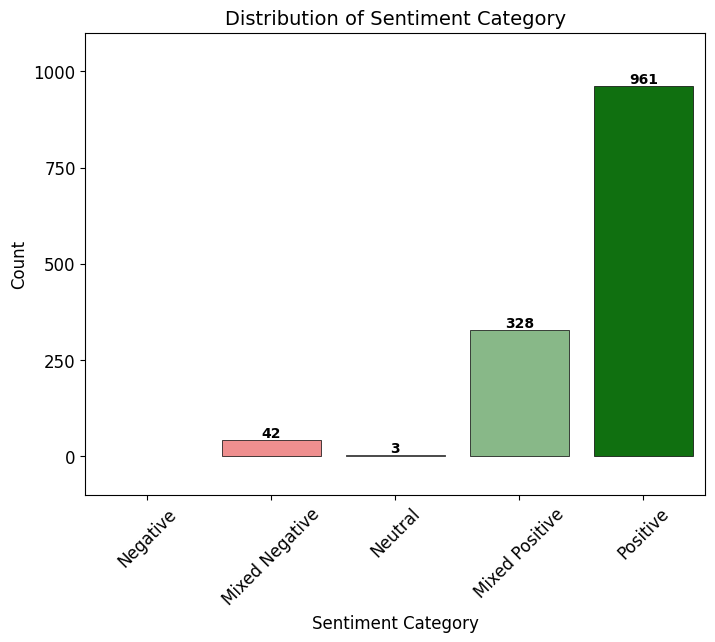

In [18]:
# --------------------------------------------------------
# --> 📒[E.4] Output distribution of sentiment category :
# --------------------------------------------------------
# Define ordering
sentiment_order = ['Negative', 'Mixed Negative', 'Neutral', 'Mixed Positive', 'Positive']
bucket_order = ['-1.0 to -0.5', '-0.49 to 0.0', '0.0 to 0.49', '0.5 to 1.0']

df_fixed['SentimentCategory'] = pd.Categorical(df_fixed['SentimentCategory'], categories=sentiment_order, ordered=True)
df_fixed['SentimentBucket'] = pd.Categorical(df_fixed['SentimentBucket'], categories=bucket_order, ordered=True)

# Create the custom red-white-green colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_rwg", ["red", "white", "green"], N=len(sentiment_order))
custom_palette = [custom_cmap(i / (len(sentiment_order) - 1)) for i in range(len(sentiment_order))]

# Sentiment Category Plot 
plt.figure(figsize=(8, 6))
ax = sns.countplot(
    x='SentimentCategory', 
    data=df_fixed, 
    palette=custom_palette,  
    order=sentiment_order,  
    edgecolor="black",  
    linewidth=0.5       
)

# Set axis labels and title with the requested sizes
plt.xlabel("Sentiment Category", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Distribution of Sentiment Category", fontsize=14)

# Set tick label sizes
plt.xticks(rotation=45, fontsize=12)
plt.yticks([0, 250, 500, 750, 1000], fontsize=12)

# Set y-axis limits
plt.ylim(-100, 1100)

# Annotate all bars with their count
for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height())}', 
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha='center', va='bottom', fontsize=10, fontweight='bold'
    )

# Define directory and filename
save_dir = "/mnt/c/Users/Joseph/Desktop/quick/0_data/Personal/amazon/fig"
file_name = "fig_distribution_sentiment_category.png"

# Ensure the directory exists
os.makedirs(save_dir, exist_ok=True)  # Creates the directory if it doesn't exist

# Full file path
save_path = os.path.join(save_dir, file_name)

# Save the figure
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()

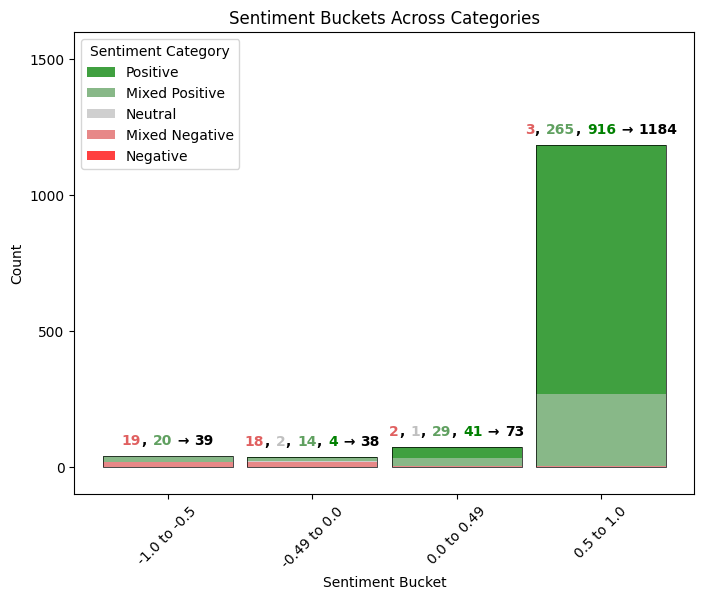

In [19]:
# ----------------------------------------------------------------------
# --> 📒[E.5] Determine most frequent of score, category, and bucket :
# ------------------------------------------------------------------

# ------------------------------------------------------
# Convert columns to categorical & define color palette
# ------------------------------------------------------
sentiment_order = ['Positive', 'Mixed Positive', 'Neutral', 'Mixed Negative', 'Negative']
bucket_order = ['-1.0 to -0.5', '-0.49 to 0.0', '0.0 to 0.49', '0.5 to 1.0']

df_fixed['SentimentCategory'] = pd.Categorical(
    df_fixed['SentimentCategory'], 
    categories=sentiment_order, 
    ordered=True)

df_fixed['SentimentBucket'] = pd.Categorical(
    df_fixed['SentimentBucket'], 
    categories=bucket_order, 
    ordered=True)

custom_cmap = LinearSegmentedColormap.from_list(
    "custom_rwg", ["green", "#C0C0C0", "red"], N=len(sentiment_order))

custom_palette = [
    custom_cmap(i / (len(sentiment_order) - 1)) for i in range(len(sentiment_order))]

# ------------------------------------------------------
# Sentiment bucket plot
# ------------------------------------------------------
plt.figure(figsize=(8, 6))
ax = sns.histplot(
    data=df_fixed, 
    x="SentimentBucket", 
    hue="SentimentCategory", 
    multiple="stack", 
    discrete=True, 
    palette=custom_palette,  
    hue_order=sentiment_order,  
    edgecolor=None,  
    linewidth=0.5,  
    shrink=0.9
)

sns.move_legend(ax, "upper left", title="Sentiment Category")

plt.xlabel("Sentiment Bucket")
plt.ylabel("Count")
plt.title("Sentiment Buckets Across Categories")
plt.ylim(-100, 1600)
plt.yticks([0, 500, 1000, 1500])
plt.xticks(rotation=45)

# ------------------------------------------------------
# Add outline and annotation:
#   [1] Define functions for annotation
# ------------------------------------------------------
def transform_pixels_to_data(ax, px_width):
    """
    Utility to convert a pixel width into data coordinates for the given Axes 'ax'.
    """
    inv = ax.transData.inverted()
    data_x0, _ = inv.transform((0, 0))
    data_x1, _ = inv.transform((px_width, 0))
    return data_x1 - data_x0

def place_colored_annotation_line(ax, base_x, base_y, items, 
                                  fontsize=10, fontweight='bold', 
                                  halign='center'):
    """
    Place a single-line annotation made of multiple (text, color, spacing) parts.
    
    items: list of tuples (text_string, text_color, spacing_after_text).
    base_x, base_y: The reference point for the entire annotation line in data coords.
                    If halign='center', the line is centered horizontally around base_x.
    """
    # First, measure total width of all pieces (in data coords) by placing them invisibly
    total_width = 0
    invisible_texts = []
    for (txt, color, space) in items:
        temp = ax.text(base_x, base_y, txt,
                       fontsize=fontsize, fontweight=fontweight,
                       color=color, alpha=0)  # invisible
        invisible_texts.append((temp, space))

        plt.draw()
        bbox = temp.get_window_extent(renderer=ax.figure.canvas.get_renderer())
        px_width = bbox.width

        data_w = transform_pixels_to_data(ax, px_width)
        total_width += data_w + space

    # Remove invisible texts
    for (t, _) in invisible_texts:
        t.remove()

    # Center or left align
    if halign == 'center':
        start_x = base_x - total_width / 2
    else:
        start_x = base_x

    # Place visible text pieces
    current_x = start_x
    for (txt, color, space) in items:
        temp = ax.text(
            current_x, base_y, txt,
            fontsize=fontsize, fontweight=fontweight, 
            color=color, alpha=1,  # fully visible
            ha='left', va='bottom'
        )
        plt.draw()
        bbox = temp.get_window_extent(renderer=ax.figure.canvas.get_renderer())
        px_width = bbox.width
        data_w = transform_pixels_to_data(ax, px_width)

        current_x += data_w + space
        
# ------------------------------------------------------
# Add outline and annotation:
#   [2] Collect info to describe stacked bars
#       We'll store for each x-center:
#         total_height: sum of sub-bar heights
#         bar_width:   from the first sub-bar
#         subbars:     list of (height, color)
# ------------------------------------------------------
bucket_map = {}
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height <= 0:
            continue
        x_center = bar.get_x() + bar.get_width() / 2
        bar_color = bar.get_facecolor()  # RGBA
        bar_width = bar.get_width()

        if x_center not in bucket_map:
            bucket_map[x_center] = {
                'width': bar_width,
                'subbars': []
            }
        bucket_map[x_center]['subbars'].append((height, bar_color))

# ------------------------------------------------------
# Add outline and annotation:
#   [3] Draw a SINGLE outline around each stacked bar
#       from y=0 up to the sum of sub-bar heights.
# ------------------------------------------------------
for x_center, info in bucket_map.items():
    subbars = info['subbars']
    bar_width = info['width']
    total_height = sum(h for (h, _) in subbars)

    # left coordinate
    left = x_center - bar_width/2
    # We'll draw a rectangle from (left, 0) to (left+bar_width, total_height)
    rect = patches.Rectangle(
        (left, 0),          # bottom-left corner
        bar_width,          # width
        total_height,       # height
        facecolor='none',   # no fill, so we can see sub-bars
        edgecolor='black',  # black outline
        linewidth=0.5
    )
    ax.add_patch(rect)

# ------------------------------------------------------
# Add outline and annotation:
#    [4] Annotate each bar on top with sub-bar counts
#        + "→ total" in black, using defined functions
# ------------------------------------------------------
offset = 30 
for x_center, info in bucket_map.items():
    subbars = info['subbars']
    total_height = sum(h for (h, _) in subbars)
    if total_height == 0:
        continue

    # Build the annotation pieces, e.g. "5" (red), ", " (black), "10" (gray), " → " (black), "15" (black)
    items = []
    for i, (h, c) in enumerate(subbars):
        items.append((str(int(h)), c, 0.005))   # sub-bar count in color c
        if i < len(subbars) - 1:
            items.append((", ", "black", 0.005))

    # Add arrow and total in black
    items.append((" → ", "black", 0.001))
    items.append((str(int(total_height)), "black", 0.0))

    place_colored_annotation_line(
        ax,
        base_x=x_center,
        base_y=total_height + offset,
        items=items,
        halign='center'   # center horizontally above the bar
    )


# Define directory and filename
save_dir = "/mnt/c/Users/Joseph/Desktop/quick/0_data/Personal/amazon/fig"
file_name = "fig_distribution_sentiment_bucket.png"

# Ensure the directory exists
os.makedirs(save_dir, exist_ok=True)  # Creates the directory if it doesn't exist

# Full file path
save_path = os.path.join(save_dir, file_name)

# Save the figure
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()


Plot saved to /mnt/c/Users/Joseph/Desktop/quick/0_data/Personal/amazon/fig/category_main_all_reviews_sentiment.png


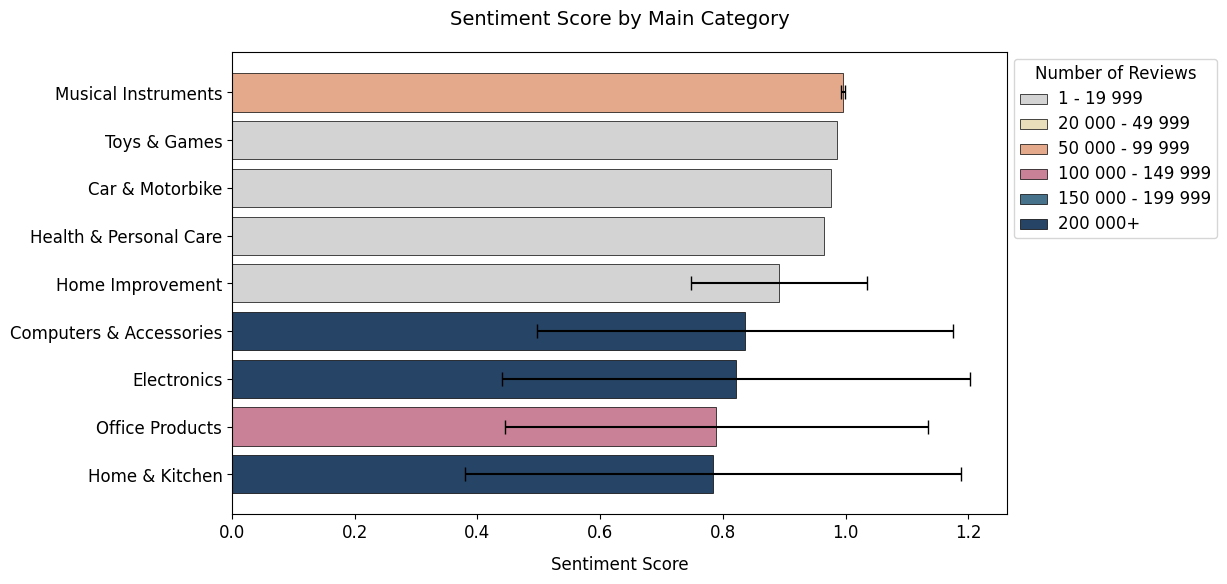

In [20]:
# ===============================
# 🔖[E] Analysis Deep Dive 
# ===============================

# -----------------------------------------------------------------
# --> 📒[E.1] Sentiment Score by Main Category (category_level1) :
# ----------------------------------------------------------------- 

# -----------------------------
# Aggregate Data by Main Category
# -----------------------------
df_aggregated_main = df_fixed.groupby('category_level1').agg(
    rating_count_conv_sum=('rating_count_conv', 'sum'),
    mean_sentiment=('SentimentScore', 'mean'),
    std_sentiment=('SentimentScore', 'std'),
    count=('category_level1', 'size')
).reset_index()

df_aggregated_main = df_aggregated_main.sort_values(by='mean_sentiment', ascending=False)

# -----------------------------
# Assign Review Count Categories
# -----------------------------
def assign_main_review_category(val):
    if val < 20000:
        return '1 - 19 999'
    elif 20000 <= val < 50000:
        return '20 000 - 49 999'
    elif 50000 <= val < 100000:
        return '50 000 - 99 999'
    elif 100000 <= val < 150000:
        return '100 000 - 149 999'
    elif 150000 <= val < 200000:
        return '150 000 - 199 999'
    else:
        return '200 000+'

df_aggregated_main['rating_count_category'] = df_aggregated_main['rating_count_conv_sum'].apply(assign_main_review_category)

# -----------------------------
# Define Legend Order and Color Mapping
# -----------------------------
main_hue_order = [
    '1 - 19 999', 
    '20 000 - 49 999', 
    '50 000 - 99 999', 
    '100 000 - 149 999', 
    '150 000 - 199 999', 
    '200 000+'
]

main_color_mapping = {
    '1 - 19 999': '#D3D3D3',         # Light Gray
    '20 000 - 49 999': '#F0E2B1',
    '50 000 - 99 999': '#F3A47C',
    '100 000 - 149 999': '#D47592',
    '150 000 - 199 999': '#3B7796',
    '200 000+': '#1C436F'
}

# -----------------------------
# Define Label Settings
# -----------------------------
x_setting = {
    "label": "Sentiment Score",
    "fontsize": 12,
    "labelpad": 10,
    "x_min": None,
    "x_max": None,
    "x_ticks": None,
    "xtick_fontsize": 12
}
y_setting = {
    "label": "",
    "fontsize": 12,
    "labelpad": 10,
    "ytick_fontsize": 12
}
title_setting = {
    "title": "Sentiment Score by Main Category",
    "fontsize": 14,
    "pad": 20
}
legend_setting = {
    "title": "Number of Reviews",
    "loc": "upper left",
    "bbox_to_anchor": (1, 1),
    "title_fontsize": 12,
    "entry_fontsize": 12
}

# -----------------------------
# Plotting Function with Error Bars
# -----------------------------
def plot_sentiment(df, legend_order, title, color_mapping, 
                   save_file=None, save_directory=None,
                   use_axis_coords=False,
                   x_setting=None, y_setting=None, legend_setting=None, title_setting=None):
    
    if x_setting is None:
        x_setting = {"label": "Sentiment Score", "fontsize": 12, "labelpad": 10,
                     "x_min": None, "x_max": None, "x_ticks": None, "xtick_fontsize": 12}
    if y_setting is None:
        y_setting = {"label": "", "fontsize": 12, "labelpad": 10, "ytick_fontsize": 12}
    if title_setting is None:
        title_setting = {"title": title, "fontsize": 14, "pad": 20}
    else:
        title_setting["title"] = title
    if legend_setting is None:
        legend_setting = {"title": "Number of Reviews", "loc": "upper left", "bbox_to_anchor": (1, 1),
                          "title_fontsize": 12, "entry_fontsize": 12}
    
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=df,
        x='mean_sentiment',
        y='category_level1',
        hue='rating_count_category',
        hue_order=legend_order,
        palette=color_mapping,
        errorbar=None  # disable built-in error bars
    )
    
    # Add a black border to each bar
    for bar in ax.patches:
        bar.set_edgecolor("black")
        bar.set_linewidth(0.5)
    
    # Build mapping for y-axis positions based on category labels
    y_labels = [label.get_text() for label in ax.get_yticklabels()]
    y_positions = ax.get_yticks()
    y_mapping = dict(zip(y_labels, y_positions))
    
    # Loop over each row and add horizontal error bars with capsize 5
    for _, row in df.iterrows():
        cat = row['category_level1']
        if cat in y_mapping:
            x_val = row['mean_sentiment']
            err_val = row['std_sentiment']
            y_val = y_mapping[cat]
            plt.errorbar(x_val, y_val, xerr=err_val, fmt='none', color='black', capsize=5)
    
    if x_setting.get("x_min") is not None or x_setting.get("x_max") is not None:
        plt.xlim(x_setting.get("x_min"), x_setting.get("x_max"))
    if x_setting.get("x_ticks") is not None:
        plt.xticks(x_setting.get("x_ticks"))
    
    plt.setp(ax.get_xticklabels(), fontsize=x_setting.get("xtick_fontsize", 12))
    plt.setp(ax.get_yticklabels(), fontsize=y_setting.get("ytick_fontsize", 12))
    
    plt.xlabel(x_setting.get("label", "Sentiment Score"), fontsize=x_setting.get("fontsize", 12),
               labelpad=x_setting.get("labelpad", 10))
    plt.ylabel(y_setting.get("label", ""), fontsize=y_setting.get("fontsize", 12),
               labelpad=y_setting.get("labelpad", 10))
    plt.title(title_setting.get("title", title), fontsize=title_setting.get("fontsize", 14),
              pad=title_setting.get("pad", 20))
    
    leg = plt.legend(**{k: v for k, v in legend_setting.items() if k not in ["title_fontsize", "entry_fontsize"]})
    if leg.get_title() is not None and "title_fontsize" in legend_setting:
        leg.get_title().set_fontsize(legend_setting["title_fontsize"])
    if "entry_fontsize" in legend_setting:
        for text in leg.get_texts():
            text.set_fontsize(legend_setting["entry_fontsize"])
    
    if save_file:
        if save_directory:
            os.makedirs(save_directory, exist_ok=True)
            filepath = os.path.join(save_directory, save_file)
        else:
            filepath = save_file
        plt.savefig(filepath, bbox_inches='tight')
        print(f"Plot saved to {filepath}")
    
    plt.show()

# -----------------------------
# Call the Plotting Function
# -----------------------------
plot_sentiment(
    df_aggregated_main,
    main_hue_order,
    "Sentiment Score by Main Category",
    main_color_mapping,
    save_file="category_main_all_reviews_sentiment.png",
    save_directory="/mnt/c/Users/Joseph/Desktop/quick/0_data/Personal/amazon/fig/",
    use_axis_coords=True,
    x_setting=x_setting,
    y_setting=y_setting,
    legend_setting=legend_setting,
    title_setting=title_setting
)

# -----------------------------
# Display the Aggregated Table
# -----------------------------
def display_table(df, title):
    # Select the desired columns and reset the index
    df = df[['category_level1', 'count', 'rating_count_conv_sum','mean_sentiment', 'std_sentiment']].reset_index(drop=True)
    # Insert a sequential numbering column
    df.insert(0, 'No.', df.index + 1)
    # Rename columns for display
    df = df.rename(columns={
        'category_level1': 'Main Category',
        'count': 'Count',
        'rating_count_conv_sum' : 'Number of Reviews',
        'mean_sentiment': 'Mean Sentiment Score',
        'std_sentiment': 'Standard Deviation'
    })
    display(HTML(f"<h2>{title}</h2>"))
    display(HTML(df.to_html(index=False, justify='left')))

# Display the table for all main categories
display_table(df_aggregated_main, "Category Level 1 | Aggregated Data by Main Category")



Plot saved to /mnt/c/Users/Joseph/Desktop/quick/0_data/Personal/amazon/fig/category_level2_high_reviews_sentiment.png


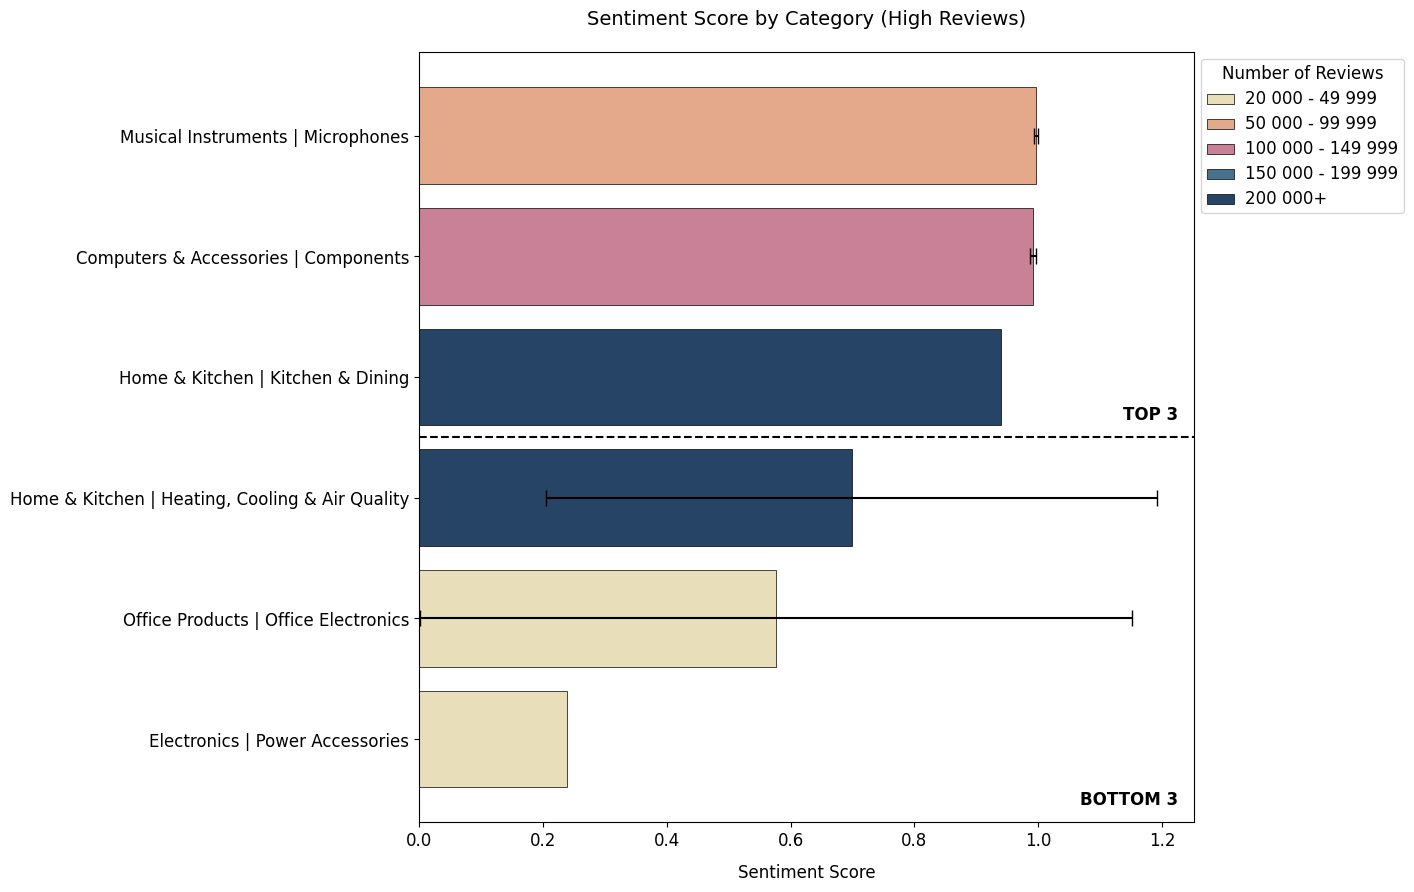

Plot saved to /mnt/c/Users/Joseph/Desktop/quick/0_data/Personal/amazon/fig/category_level2_low_reviews_sentiment.png


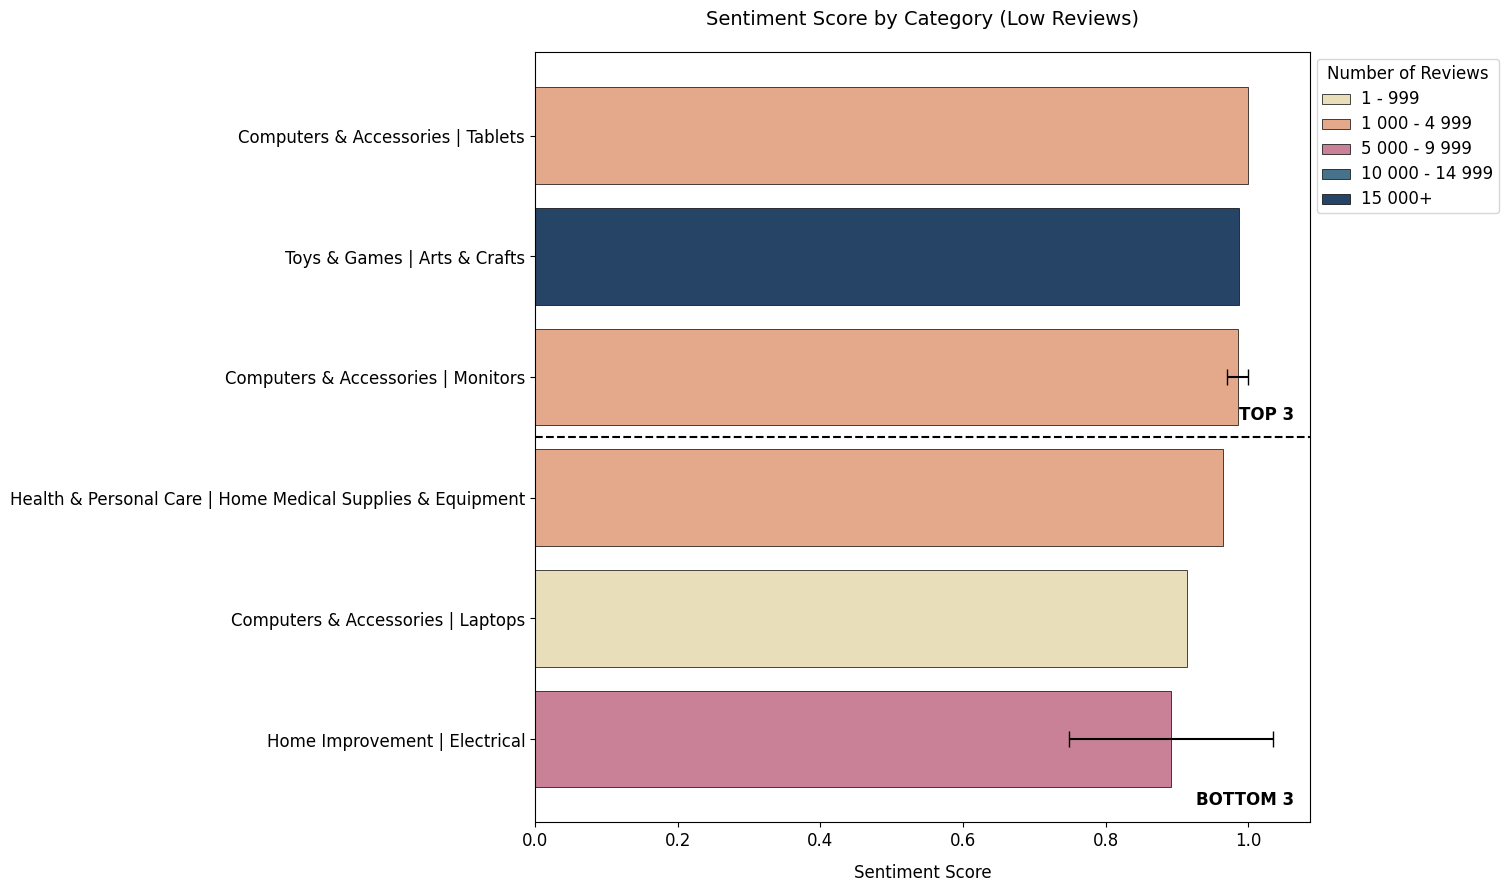

In [21]:
# ---------------------------------------------------------------------------
# --> 📒[E.2] Sentiment Score by Main-Immediate Category (category_level2) :
# --------------------------------------------------------------------------- 

# Compute count, mean and standard deviation for SentimentScore in the aggregated dataframe
df_aggregated = df_fixed.groupby('category_level2').agg(
    count=('category_level2', 'size'),
    rating_count_conv_sum=('rating_count_conv', 'sum'),
    mean_sentiment=('SentimentScore', 'mean'),
    std_sentiment=('SentimentScore', 'std')
).reset_index()

df_aggregated = df_aggregated.sort_values(by='mean_sentiment', ascending=False)

# Split the data into high and low review sets
high_review_df = df_aggregated[df_aggregated['rating_count_conv_sum'] >= 20000].copy()
low_review_df = df_aggregated[df_aggregated['rating_count_conv_sum'] < 20000].copy()

# --- Categorization Functions for Review Count ---
def assign_high_review_category(val):
    if 20000 <= val < 50000:
        return '20 000 - 49 999'
    elif 50000 <= val < 100000:
        return '50 000 - 99 999'
    elif 100000 <= val < 150000:
        return '100 000 - 149 999'
    elif 150000 <= val < 200000:
        return '150 000 - 199 999'
    else:
        return '200 000+'

def assign_low_review_category(val):
    if val < 1000:
        return '1 - 999'
    elif 1000 <= val < 5000:
        return '1 000 - 4 999'
    elif 5000 <= val < 10000:
        return '5 000 - 9 999'
    elif 10000 <= val < 15000:
        return '10 000 - 14 999'
    else:
        return '15 000+'

high_review_df['rating_count_category'] = high_review_df['rating_count_conv_sum'].apply(assign_high_review_category)
low_review_df['rating_count_category'] = low_review_df['rating_count_conv_sum'].apply(assign_low_review_category)

# --- Define Legend Order and Updated Color Mapping ---
high_legend_order = ['20 000 - 49 999', '50 000 - 99 999', '100 000 - 149 999', '150 000 - 199 999', '200 000+']
high_color_mapping = {
    '20 000 - 49 999': '#F0E2B1',
    '50 000 - 99 999': '#F3A47C',
    '100 000 - 149 999': '#D47592',
    '150 000 - 199 999': '#3B7796',
    '200 000+': '#1C436F'
}

low_legend_order = ['1 - 999', '1 000 - 4 999', '5 000 - 9 999', '10 000 - 14 999', '15 000+']
low_color_mapping = {
    '1 - 999': '#F0E2B1',
    '1 000 - 4 999': '#F3A47C',
    '5 000 - 9 999': '#D47592',
    '10 000 - 14 999': '#3B7796',
    '15 000+': '#1C436F'
}

# --- Dictionaries for Label Settings ---
x_setting = {
    "label": "Sentiment Score",
    "fontsize": 12,
    "labelpad": 10,
    "x_min": None,       # e.g., 0
    "x_max": None,       # e.g., 1.0
    "x_ticks": None,     # e.g., [0, 0.25, 0.5, 0.75, 1.0]
    "xtick_fontsize": 12
}
y_setting = {
    "label": "", 
    "fontsize": 12, 
    "labelpad": 10,
    "ytick_fontsize": 12
}
title_setting = {
    "title": None,  # This will be updated per plot call
    "fontsize": 14,
    "pad": 20
}
legend_setting = {
    "title": "Number of Reviews", 
    "loc": "upper left", 
    "bbox_to_anchor": (1, 1),
    "title_fontsize": 12,
    "entry_fontsize": 12
}

# --- Plotting Function ---
def plot_sentiment(df, category_labels, legend_order, title, color_mapping, 
                   filter_top=None, filter_bot=None, save_file=None, save_directory=None,
                   ann_top_x=None, ann_top_y=None, ann_bot_x=None, ann_bot_y=None,
                   use_axis_coords=False,
                   x_setting=None, y_setting=None, legend_setting=None, title_setting=None):
    
    # Use default settings if not provided
    if x_setting is None:
        x_setting = {"label": "Sentiment Score", "fontsize": 12, "labelpad": 10,
                     "x_min": None, "x_max": None, "x_ticks": None, "xtick_fontsize": 10}
    if y_setting is None:
        y_setting = {"label": "", "fontsize": 12, "labelpad": 10, "ytick_fontsize": 10}
    if title_setting is None:
        title_setting = {"title": title, "fontsize": 14, "pad": 20}
    else:
        title_setting["title"] = title  # update the plot title
    if legend_setting is None:
        legend_setting = {"title": "Number of Reviews", "loc": "upper left", "bbox_to_anchor": (1, 1),
                          "title_fontsize": 12, "entry_fontsize": 10}
    
    # Optionally filter and concatenate top and bottom portions of the data
    if filter_top and filter_bot:
        df_top = df.head(filter_top)
        df_bot = df.tail(filter_bot)
        df = pd.concat([df_top, df_bot])
    
    plt.figure(figsize=(10, 10))
    ax = sns.barplot(
        data=df,
        x='mean_sentiment',
        y='category_level2',
        hue='rating_count_category',
        hue_order=legend_order,
        palette=color_mapping,
        errorbar=None  # Disable built-in error bars (replaces ci=None)
    )
    
    # Add a 0.5-width black outline around each bar
    for bar in ax.patches:
        bar.set_edgecolor("black")
        bar.set_linewidth(0.5)
    
    # Build a mapping from category label to its y-axis position
    y_labels = [label.get_text() for label in ax.get_yticklabels()]
    y_positions = ax.get_yticks()
    y_mapping = dict(zip(y_labels, y_positions))
    
    # Loop over each row in df and add an error bar based on std_sentiment
    for _, row in df.iterrows():
        cat = row['category_level2']
        if cat in y_mapping:
            x_val = row['mean_sentiment']
            err_val = row['std_sentiment']
            y_val = y_mapping[cat]
            plt.errorbar(x_val, y_val, xerr=err_val, fmt='none', color='black', capsize=6)
    
    if filter_top and filter_bot:
        sep_index = len(df_top) - 0.5
        plt.axhline(y=sep_index, color='black', linestyle='dashed')
        transform = ax.transAxes if use_axis_coords else ax.transData
        ax.text(ann_top_x or 0.98, ann_top_y or 0.53, f"TOP {filter_top}", fontsize=12, fontweight='bold',
                va='center', ha='right', color='black', transform=transform, clip_on=False)
        ax.text(ann_bot_x or 0.98, ann_bot_y or 0.03, f"BOTTOM {filter_bot}", fontsize=12, fontweight='bold',
                va='center', ha='right', color='black', transform=transform, clip_on=False)
    
    # Set x-axis limits and ticks if provided in x_setting
    if x_setting.get("x_min") is not None or x_setting.get("x_max") is not None:
        plt.xlim(x_setting.get("x_min"), x_setting.get("x_max"))
    if x_setting.get("x_ticks") is not None:
        plt.xticks(x_setting.get("x_ticks"))
    
    # Set the tick label font sizes
    plt.setp(ax.get_xticklabels(), fontsize=x_setting.get("xtick_fontsize", 10))
    plt.setp(ax.get_yticklabels(), fontsize=y_setting.get("ytick_fontsize", 10))
    
    # Set labels and title using the provided dictionaries
    plt.xlabel(x_setting.get("label", "Sentiment Score"), fontsize=x_setting.get("fontsize", 12),
               labelpad=x_setting.get("labelpad", 10))
    plt.ylabel(y_setting.get("label", ""), fontsize=y_setting.get("fontsize", 12),
               labelpad=y_setting.get("labelpad", 10))
    plt.title(title_setting.get("title", title), fontsize=title_setting.get("fontsize", 14),
              pad=title_setting.get("pad", 20))
    
    # Create the legend and apply font size settings for the legend title and entries
    leg = plt.legend(**{k: v for k, v in legend_setting.items() if k not in ["title_fontsize", "entry_fontsize"]})
    if leg.get_title() is not None and "title_fontsize" in legend_setting:
        leg.get_title().set_fontsize(legend_setting["title_fontsize"])
    if "entry_fontsize" in legend_setting:
        for text in leg.get_texts():
            text.set_fontsize(legend_setting["entry_fontsize"])
    
    if save_file:
        if save_directory:
            os.makedirs(save_directory, exist_ok=True)
            filepath = os.path.join(save_directory, save_file)
        else:
            filepath = save_file
        plt.savefig(filepath, bbox_inches='tight')
        print(f"Plot saved to {filepath}")
    
    plt.show()

# --- Plotting the Data ---

# For High Reviews
plot_sentiment(
    high_review_df,
    assign_high_review_category,
    high_legend_order,
    "Sentiment Score by Category (High Reviews)",
    high_color_mapping,
    filter_top=3, filter_bot=3,
    save_file="category_level2_high_reviews_sentiment.png",
    save_directory="/mnt/c/Users/Joseph/Desktop/quick/0_data/Personal/amazon/fig/",
    use_axis_coords=True,
    x_setting=x_setting,
    y_setting=y_setting,
    legend_setting=legend_setting,
    title_setting=title_setting
)

# For Low Reviews
plot_sentiment(
    low_review_df,
    assign_low_review_category,
    low_legend_order,
    "Sentiment Score by Category (Low Reviews)",
    low_color_mapping,
    filter_top=3, filter_bot=3,
    save_file="category_level2_low_reviews_sentiment.png",
    save_directory="/mnt/c/Users/Joseph/Desktop/quick/0_data/Personal/amazon/fig/",
    use_axis_coords=True,
    x_setting=x_setting,
    y_setting=y_setting,
    legend_setting=legend_setting,
    title_setting=title_setting
)

# --- Print Summary Tables ---
# Split the high-review and low-review aggregated data into top and bottom subsets.
# Here, we use the same number of rows (5) as in the plotting filters.
high_top = high_review_df.head(5).copy()
high_bot = high_review_df.tail(5).copy()
low_top = low_review_df.head(5).copy()
low_bot = low_review_df.tail(5).copy()

def display_table(df, title):
    df = df[['category_level2', 'count', 'mean_sentiment', 'std_sentiment']].reset_index(drop=True)
    df.insert(0, 'No.', df.index + 1)
    df = df.rename(columns={
        'category_level2': 'Category (First and Second)',
        'count': 'Count',
        'mean_sentiment': 'Mean Sentiment Score',
        'std_sentiment': 'Standard Deviation'
    })
    display(HTML(f"<h2>{title}</h2>"))
    display(HTML(df.to_html(index=False, justify='left')))

display_table(high_top, "Category Level 2 | High Reviews - Top Categories")
display_table(high_bot, "Category Level 2 | High Reviews - Bottom Categories")
display_table(low_top, "Category Level 2 | Low Reviews - Top Categories")
display_table(low_bot, "Category Level 2 | Low Reviews - Bottom Categories")


Plot saved to /mnt/c/Users/Joseph/Desktop/quick/0_data/Personal/amazon/fig/category_level3_high_reviews_sentiment.png


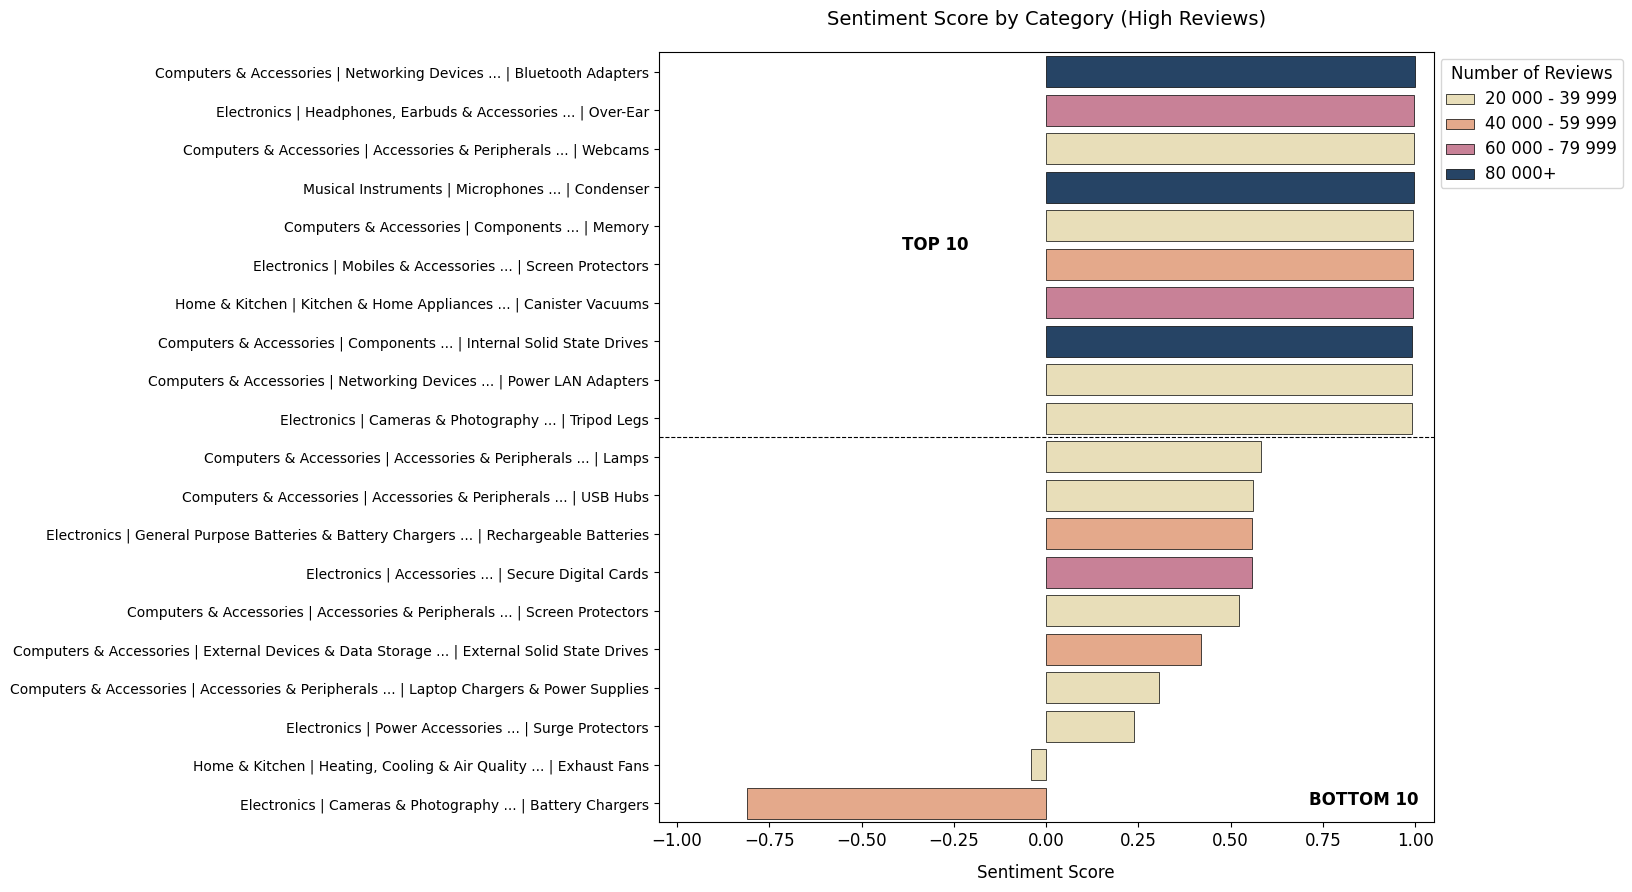

Plot saved to /mnt/c/Users/Joseph/Desktop/quick/0_data/Personal/amazon/fig/category_level3_low_reviews_sentiment.png


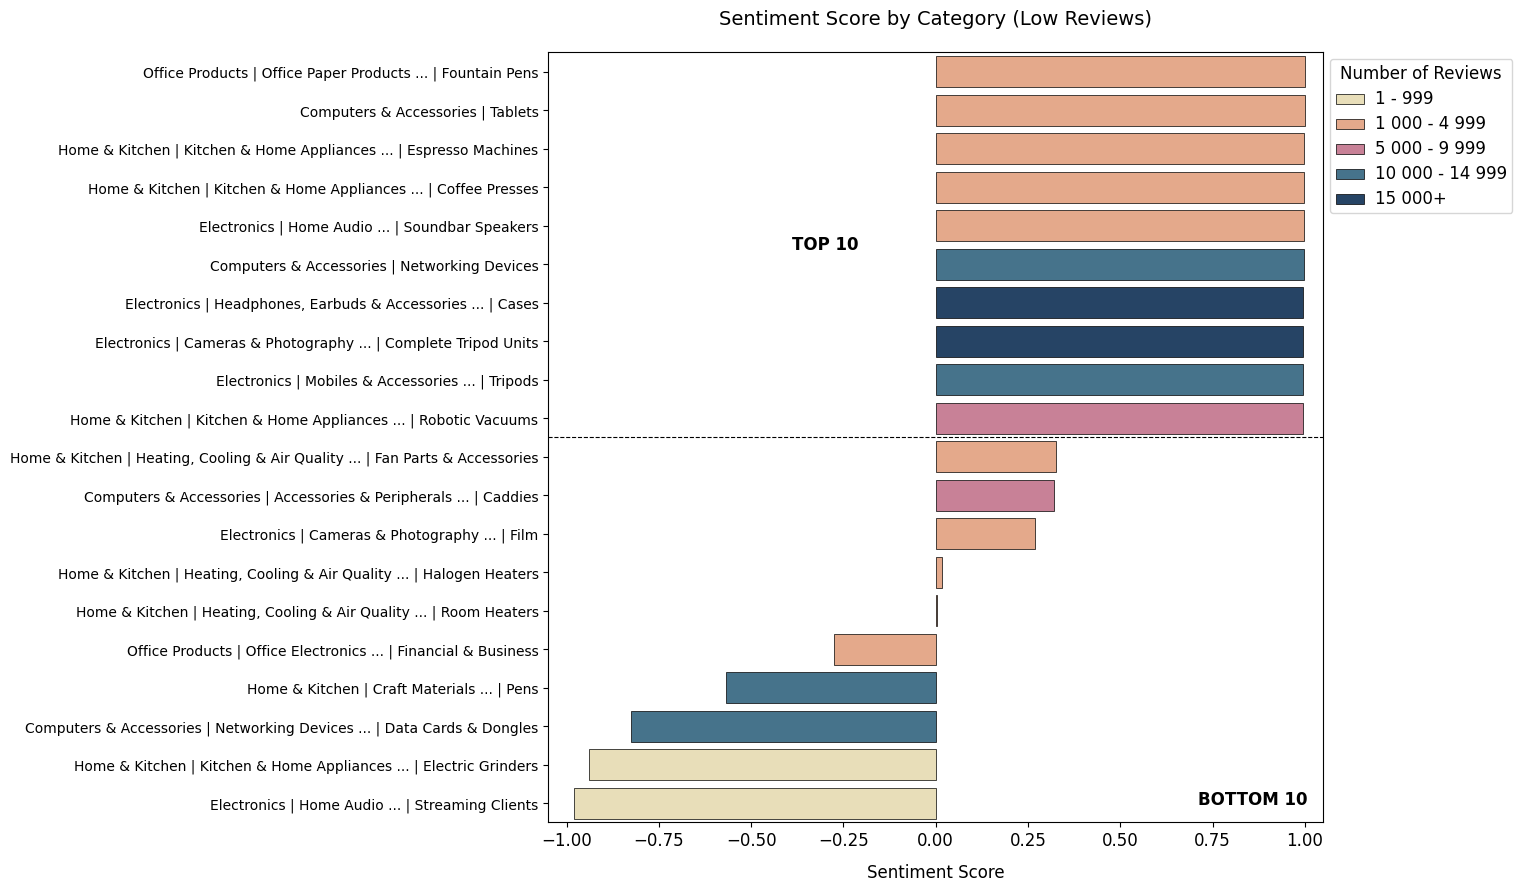

In [31]:
# --------------------------------------------------------------------------------
# --> 📒[E.3] Sentiment Score by Main-Immediate-Last Category (category_level3) :
# --------------------------------------------------------------------------------

# Groupby categories
df_aggregated = df_fixed.groupby('category_level3').agg(
    rating_count_conv_sum=('rating_count_conv', 'sum'),
    mean_sentiment=('SentimentScore', 'mean')
).reset_index()

# Add complete category mapping (using the first occurrence for each truncated category)
complete_category_mapping = df_fixed.groupby('category_level3')['category'].first().to_dict()
df_aggregated['category'] = df_aggregated['category_level3'].map(complete_category_mapping)

df_aggregated = df_aggregated.sort_values(by='mean_sentiment', ascending=False)

# Split the aggregated data into high and low review sets
high_review_df = df_aggregated[df_aggregated['rating_count_conv_sum'] >= 20000].copy()
low_review_df = df_aggregated[df_aggregated['rating_count_conv_sum'] < 20000].copy()

# --- Updated Categorization Functions ---
def assign_high_review_category(val):
    if 20000 <= val < 40000:
        return '20 000 - 39 999'
    elif 40000 <= val < 60000:
        return '40 000 - 59 999'
    elif 60000 <= val < 80000:
        return '60 000 - 79 999'
    else:
        return '80 000+'

def assign_low_review_category(val):
    if val < 1000:
        return '1 - 999'
    elif 1000 <= val < 5000:
        return '1 000 - 4 999'
    elif 5000 <= val < 10000:
        return '5 000 - 9 999'
    elif 10000 <= val < 15000:
        return '10 000 - 14 999'
    else:
        return '15 000+'

high_review_df['rating_count_category'] = high_review_df['rating_count_conv_sum'].apply(assign_high_review_category)
low_review_df['rating_count_category'] = low_review_df['rating_count_conv_sum'].apply(assign_low_review_category)

# --- Updated Legend Order and Color Mapping for High Reviews ---
high_legend_order = ['20 000 - 39 999', '40 000 - 59 999', '60 000 - 79 999', '80 000+']
high_color_mapping = {
    '20 000 - 39 999': '#F0E2B1',  # Lightest color for lowest category
    '40 000 - 59 999': '#F3A47C',  # Light Salmon
    '60 000 - 79 999': '#D47592',  # Charm
    '80 000+': '#1C436F'           # Rainbow Indigo
}

low_legend_order = ['1 - 999', '1 000 - 4 999', '5 000 - 9 999', '10 000 - 14 999', '15 000+']
low_color_mapping = {
    '1 - 999': '#F0E2B1',          # Lightest color for lowest category
    '1 000 - 4 999': '#F3A47C',    # Light Salmon
    '5 000 - 9 999': '#D47592',    # Charm
    '10 000 - 14 999': '#3B7796',  # Jelly Bean Blue
    '15 000+': '#1C436F'           # Rainbow Indigo
}

# --- Dictionary Settings for Labels ---
x_setting = {
    "label": "Sentiment Score",
    "fontsize": 12,
    "labelpad": 10,
    "x_min": -1.05,       
    "x_max": 1.05,       
    "x_ticks": [-1, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0],
    "xtick_fontsize": 12
}
y_setting = {
    "label": "", 
    "fontsize": 12, 
    "labelpad": 10,
    "ytick_fontsize": 10
}
title_setting = {
    "title": None,  # This will be updated per plot call
    "fontsize": 14,
    "pad": 20
}
legend_setting = {
    "title": "Number of Reviews", 
    "loc": "upper left", 
    "bbox_to_anchor": (1, 1),
    "title_fontsize": 12,
    "entry_fontsize": 12
}

# --- Plotting Function ---
def plot_sentiment(df, category_labels, legend_order, title, color_mapping, 
                   filter_top=None, filter_bot=None, save_file=None, save_directory=None,
                   ann_top_x=None, ann_top_y=None, ann_bot_x=None, ann_bot_y=None,
                   use_axis_coords=False,
                   x_setting=None, y_setting=None, legend_setting=None, title_setting=None):
    
    # Use default settings if not provided
    if x_setting is None:
        x_setting = {"label": "Sentiment Score", "fontsize": 12, "labelpad": 10,
                     "x_min": None, "x_max": None, "x_ticks": None, "xtick_fontsize": 10}
    if y_setting is None:
        y_setting = {"label": "", "fontsize": 12, "labelpad": 10, "ytick_fontsize": 10}
    if title_setting is None:
        title_setting = {"title": title, "fontsize": 14, "pad": 20}
    else:
        title_setting["title"] = title  # update the plot title
    if legend_setting is None:
        legend_setting = {"title": "Number of Reviews", "loc": "upper left", "bbox_to_anchor": (1, 1),
                          "title_fontsize": 12, "entry_fontsize": 10}
    
    # Optionally filter and concatenate top and bottom portions of the data
    if filter_top and filter_bot:
        df_top = df.head(filter_top)
        df_bot = df.tail(filter_bot)
        df = pd.concat([df_top, df_bot])
    
    plt.figure(figsize=(10, 10))
    ax = sns.barplot(
        data=df,
        x='mean_sentiment',
        y='category_level3',
        hue='rating_count_category',
        hue_order=legend_order,
        palette=color_mapping
    )
    
    # Add a 0.5-width black outline around each bar
    for bar in ax.patches:
        bar.set_edgecolor("black")
        bar.set_linewidth(0.5)
    
    if filter_top and filter_bot:
        sep_index = len(df_top) - 0.5
        plt.axhline(y=sep_index, color='black', linestyle='dashed', linewidth=0.8)
        transform = ax.transAxes if use_axis_coords else ax.transData
        ax.text(ann_top_x or 0.4, ann_top_y or 0.75, f"TOP {filter_top}", fontsize=12, fontweight='bold',
                va='center', ha='right', color='black', transform=transform, clip_on=False)
        ax.text(ann_bot_x or 0.98, ann_bot_y or 0.03, f"BOTTOM {filter_bot}", fontsize=12, fontweight='bold',
                va='center', ha='right', color='black', transform=transform, clip_on=False)
    
    # Set x-axis limits and ticks if provided in x_setting
    if x_setting.get("x_min") is not None or x_setting.get("x_max") is not None:
        plt.xlim(x_setting.get("x_min"), x_setting.get("x_max"))
    if x_setting.get("x_ticks") is not None:
        plt.xticks(x_setting.get("x_ticks"))
    
    # Set tick label font sizes
    plt.setp(ax.get_xticklabels(), fontsize=x_setting.get("xtick_fontsize", 10))
    plt.setp(ax.get_yticklabels(), fontsize=y_setting.get("ytick_fontsize", 10))
    
    # Set labels and title using the provided dictionaries
    plt.xlabel(x_setting.get("label", "Sentiment Score"), fontsize=x_setting.get("fontsize", 12),
               labelpad=x_setting.get("labelpad", 10))
    plt.ylabel(y_setting.get("label", ""), fontsize=y_setting.get("fontsize", 12),
               labelpad=y_setting.get("labelpad", 10))
    plt.title(title_setting.get("title", title), fontsize=title_setting.get("fontsize", 14),
              pad=title_setting.get("pad", 20))
    
    # Create the legend and update font sizes for the legend title and entries
    leg = plt.legend(**{k: v for k, v in legend_setting.items() if k not in ["title_fontsize", "entry_fontsize"]})
    if leg.get_title() is not None and "title_fontsize" in legend_setting:
        leg.get_title().set_fontsize(legend_setting["title_fontsize"])
    if "entry_fontsize" in legend_setting:
        for text in leg.get_texts():
            text.set_fontsize(legend_setting["entry_fontsize"])
    
    if save_file:
        if save_directory:
            os.makedirs(save_directory, exist_ok=True)
            filepath = os.path.join(save_directory, save_file)
        else:
            filepath = save_file
        plt.savefig(filepath, bbox_inches='tight')
        print(f"Plot saved to {filepath}")
    
    plt.show()

# --- Plotting the Data ---

# Here we use filter_top and filter_bot values for plotting (e.g., top 10 and bottom 10)
plot_sentiment(
    high_review_df,
    assign_high_review_category,
    high_legend_order,
    "Sentiment Score by Category (High Reviews)",
    high_color_mapping,
    filter_top=10, filter_bot=10,
    save_file="category_level3_high_reviews_sentiment.png",
    save_directory="/mnt/c/Users/Joseph/Desktop/quick/0_data/Personal/amazon/fig/",
    use_axis_coords=True,
    x_setting=x_setting,
    y_setting=y_setting,
    legend_setting=legend_setting,
    title_setting=title_setting
)

plot_sentiment(
    low_review_df,
    assign_low_review_category,
    low_legend_order,
    "Sentiment Score by Category (Low Reviews)",
    low_color_mapping,
    filter_top=10, filter_bot=10,
    save_file="category_level3_low_reviews_sentiment.png",
    save_directory="/mnt/c/Users/Joseph/Desktop/quick/0_data/Personal/amazon/fig/",
    use_axis_coords=True,
    x_setting=x_setting,
    y_setting=y_setting,
    legend_setting=legend_setting,
    title_setting=title_setting
)

# --- Displaying Tables ---

# Split the high-review and low-review aggregated data into top and bottom subsets.
# Here, we use the same number of rows (5) as in the plotting filters.
high_top = high_review_df.head(5).copy()
high_bot = high_review_df.tail(5).copy()
low_top = low_review_df.head(5).copy()
low_bot = low_review_df.tail(5).copy()

def display_table(df, title):
    # Select and order the desired columns: complete category, truncated category, and mean sentiment
    df = df[['category', 'category_level3','rating_count_conv_sum','mean_sentiment']].reset_index(drop=True)
    df.insert(0, "No", df.index + 1)  # Add "No" column
    # Format column headers by replacing underscores with spaces and capitalizing
    df = df.rename(columns=lambda x: x.replace('_', ' ').title())
    
    # Define custom CSS to disable text wrapping in table cells
    css = """
    <style type="text/css">
        .nowrap-table td {
            white-space: nowrap;
        }
    </style>
    """
    # Convert DataFrame to an HTML table with the custom CSS class "nowrap-table"
    html_table = df.to_html(index=False, classes="nowrap-table", justify='left')
    
    # Display title and HTML table with the CSS style applied
    display(HTML(f"<h2>{title}</h2>" + css + html_table))

# Example usage:
display_table(high_top, "Category Level 3 | High Reviews - Top Categories")
display_table(high_bot, "Category Level 3 | High Reviews - Bottom Categories")
display_table(low_top, "Category Level 3 | Low Reviews - Top Categories")
display_table(low_bot, "Category Level 3 | Low Reviews - Bottom Categories")


Plot saved to /mnt/c/Users/Joseph/Desktop/quick/0_data/Personal/amazon/fig/category_level3_high_reviews_sentiment.png


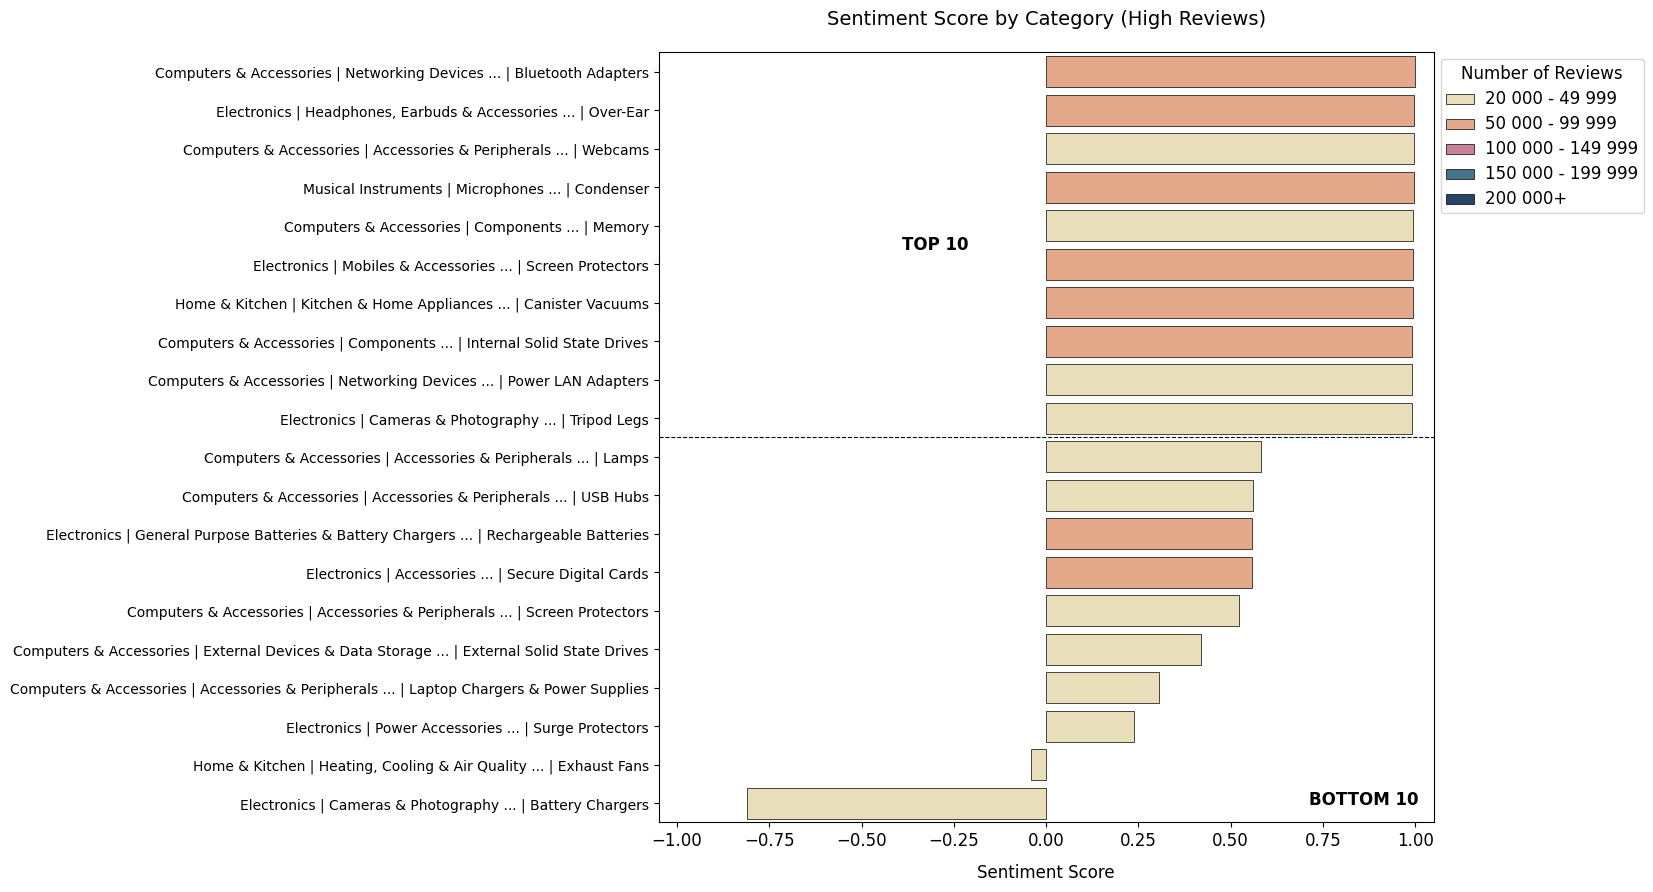

Plot saved to /mnt/c/Users/Joseph/Desktop/quick/0_data/Personal/amazon/fig/category_level3_low_reviews_sentiment.png


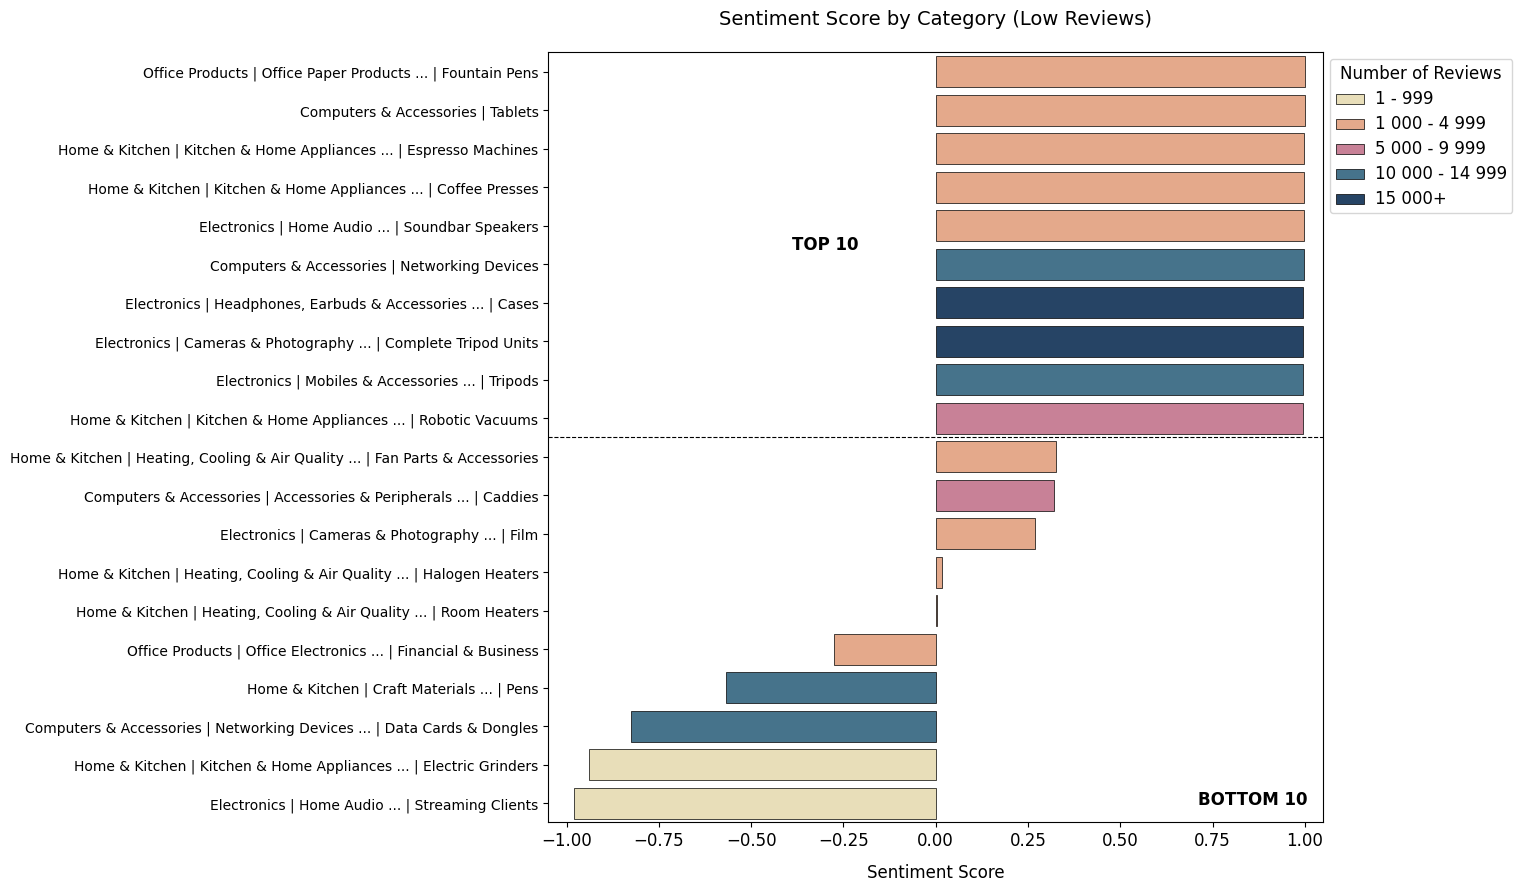

In [23]:
# --------------------------------------------------------------------------------
# --> 📒[E.3] Sentiment Score by Main-Immediate-Last Category (category_level3) :
# --------------------------------------------------------------------------------

# Groupby categories
df_aggregated = df_fixed.groupby('category_level3').agg(
    rating_count_conv_sum=('rating_count_conv', 'sum'),
    mean_sentiment=('SentimentScore', 'mean')
).reset_index()

# Add complete category mapping (using the first occurrence for each truncated category)
complete_category_mapping = df_fixed.groupby('category_level3')['category'].first().to_dict()
df_aggregated['category'] = df_aggregated['category_level3'].map(complete_category_mapping)

df_aggregated = df_aggregated.sort_values(by='mean_sentiment', ascending=False)

# Split the aggregated data into high and low review sets
high_review_df = df_aggregated[df_aggregated['rating_count_conv_sum'] >= 20000].copy()
low_review_df = df_aggregated[df_aggregated['rating_count_conv_sum'] < 20000].copy()

# --- Categorization Functions ---
def assign_high_review_category(val):
    if 20000 <= val < 50000:
        return '20 000 - 49 999'
    elif 50000 <= val < 100000:
        return '50 000 - 99 999'
    elif 100000 <= val < 150000:
        return '100 000 - 149 999'
    elif 150000 <= val < 200000:
        return '150 000 - 199 999'
    else:
        return '200 000+'

def assign_low_review_category(val):
    if val < 1000:
        return '1 - 999'
    elif 1000 <= val < 5000:
        return '1 000 - 4 999'
    elif 5000 <= val < 10000:
        return '5 000 - 9 999'
    elif 10000 <= val < 15000:
        return '10 000 - 14 999'
    else:
        return '15 000+'

high_review_df['rating_count_category'] = high_review_df['rating_count_conv_sum'].apply(assign_high_review_category)
low_review_df['rating_count_category'] = low_review_df['rating_count_conv_sum'].apply(assign_low_review_category)

# --- Define Legend Order and Color Mapping ---
high_legend_order = ['20 000 - 49 999', '50 000 - 99 999', '100 000 - 149 999', '150 000 - 199 999', '200 000+']
high_color_mapping = {
    '20 000 - 49 999': '#F0E2B1',  # Lightest color for lowest category
    '50 000 - 99 999': '#F3A47C',  # Light Salmon
    '100 000 - 149 999': '#D47592', # Charm
    '150 000 - 199 999': '#3B7796', # Jelly Bean Blue
    '200 000+': '#1C436F'           # Rainbow Indigo
}

low_legend_order = ['1 - 999', '1 000 - 4 999', '5 000 - 9 999', '10 000 - 14 999', '15 000+']
low_color_mapping = {
    '1 - 999': '#F0E2B1',          # Lightest color for lowest category
    '1 000 - 4 999': '#F3A47C',    # Light Salmon
    '5 000 - 9 999': '#D47592',    # Charm
    '10 000 - 14 999': '#3B7796',  # Jelly Bean Blue
    '15 000+': '#1C436F'           # Rainbow Indigo
}

# --- Dictionary Settings for Labels ---
x_setting = {
    "label": "Sentiment Score",
    "fontsize": 12,
    "labelpad": 10,
    "x_min": -1.05,       
    "x_max": 1.05,       
    "x_ticks": [-1, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0],
    "xtick_fontsize": 12
}
y_setting = {
    "label": "", 
    "fontsize": 12, 
    "labelpad": 10,
    "ytick_fontsize": 10
}
title_setting = {
    "title": None,  # This will be updated per plot call
    "fontsize": 14,
    "pad": 20
}
legend_setting = {
    "title": "Number of Reviews", 
    "loc": "upper left", 
    "bbox_to_anchor": (1, 1),
    "title_fontsize": 12,
    "entry_fontsize": 12
}

# --- Plotting Function ---
def plot_sentiment(df, category_labels, legend_order, title, color_mapping, 
                   filter_top=None, filter_bot=None, save_file=None, save_directory=None,
                   ann_top_x=None, ann_top_y=None, ann_bot_x=None, ann_bot_y=None,
                   use_axis_coords=False,
                   x_setting=None, y_setting=None, legend_setting=None, title_setting=None):
    
    # Use default settings if not provided
    if x_setting is None:
        x_setting = {"label": "Sentiment Score", "fontsize": 12, "labelpad": 10,
                     "x_min": None, "x_max": None, "x_ticks": None, "xtick_fontsize": 10}
    if y_setting is None:
        y_setting = {"label": "", "fontsize": 12, "labelpad": 10, "ytick_fontsize": 10}
    if title_setting is None:
        title_setting = {"title": title, "fontsize": 14, "pad": 20}
    else:
        title_setting["title"] = title  # update the plot title
    if legend_setting is None:
        legend_setting = {"title": "Number of Reviews", "loc": "upper left", "bbox_to_anchor": (1, 1),
                          "title_fontsize": 12, "entry_fontsize": 10}
    
    # Optionally filter and concatenate top and bottom portions of the data
    if filter_top and filter_bot:
        df_top = df.head(filter_top)
        df_bot = df.tail(filter_bot)
        df = pd.concat([df_top, df_bot])
    
    plt.figure(figsize=(10, 10))
    ax = sns.barplot(
        data=df,
        x='mean_sentiment',
        y='category_level3',
        hue='rating_count_category',
        hue_order=legend_order,
        palette=color_mapping
    )
    
    # Add a 0.5-width black outline around each bar
    for bar in ax.patches:
        bar.set_edgecolor("black")
        bar.set_linewidth(0.5)
    
    if filter_top and filter_bot:
        sep_index = len(df_top) - 0.5
        plt.axhline(y=sep_index, color='black', linestyle='dashed', linewidth=0.8)
        transform = ax.transAxes if use_axis_coords else ax.transData
        ax.text(ann_top_x or 0.4, ann_top_y or 0.75, f"TOP {filter_top}", fontsize=12, fontweight='bold',
                va='center', ha='right', color='black', transform=transform, clip_on=False)
        ax.text(ann_bot_x or 0.98, ann_bot_y or 0.03, f"BOTTOM {filter_bot}", fontsize=12, fontweight='bold',
                va='center', ha='right', color='black', transform=transform, clip_on=False)
    
    # Set x-axis limits and ticks if provided in x_setting
    if x_setting.get("x_min") is not None or x_setting.get("x_max") is not None:
        plt.xlim(x_setting.get("x_min"), x_setting.get("x_max"))
    if x_setting.get("x_ticks") is not None:
        plt.xticks(x_setting.get("x_ticks"))
    
    # Set tick label font sizes
    plt.setp(ax.get_xticklabels(), fontsize=x_setting.get("xtick_fontsize", 10))
    plt.setp(ax.get_yticklabels(), fontsize=y_setting.get("ytick_fontsize", 10))
    
    # Set labels and title using the provided dictionaries
    plt.xlabel(x_setting.get("label", "Sentiment Score"), fontsize=x_setting.get("fontsize", 12),
               labelpad=x_setting.get("labelpad", 10))
    plt.ylabel(y_setting.get("label", ""), fontsize=y_setting.get("fontsize", 12),
               labelpad=y_setting.get("labelpad", 10))
    plt.title(title_setting.get("title", title), fontsize=title_setting.get("fontsize", 14),
              pad=title_setting.get("pad", 20))
    
    # Create the legend and update font sizes for the legend title and entries
    leg = plt.legend(**{k: v for k, v in legend_setting.items() if k not in ["title_fontsize", "entry_fontsize"]})
    if leg.get_title() is not None and "title_fontsize" in legend_setting:
        leg.get_title().set_fontsize(legend_setting["title_fontsize"])
    if "entry_fontsize" in legend_setting:
        for text in leg.get_texts():
            text.set_fontsize(legend_setting["entry_fontsize"])
    
    if save_file:
        if save_directory:
            os.makedirs(save_directory, exist_ok=True)
            filepath = os.path.join(save_directory, save_file)
        else:
            filepath = save_file
        plt.savefig(filepath, bbox_inches='tight')
        print(f"Plot saved to {filepath}")
    
    plt.show()

# --- Plotting the Data ---

# Here we use filter_top and filter_bot values for plotting (e.g., top 10 and bottom 10)
plot_sentiment(
    high_review_df,
    assign_high_review_category,
    high_legend_order,
    "Sentiment Score by Category (High Reviews)",
    high_color_mapping,
    filter_top=10, filter_bot=10,
    save_file="category_level3_high_reviews_sentiment.png",
    save_directory="/mnt/c/Users/Joseph/Desktop/quick/0_data/Personal/amazon/fig/",
    use_axis_coords=True,
    x_setting=x_setting,
    y_setting=y_setting,
    legend_setting=legend_setting,
    title_setting=title_setting
)

plot_sentiment(
    low_review_df,
    assign_low_review_category,
    low_legend_order,
    "Sentiment Score by Category (Low Reviews)",
    low_color_mapping,
    filter_top=10, filter_bot=10,
    save_file="category_level3_low_reviews_sentiment.png",
    save_directory="/mnt/c/Users/Joseph/Desktop/quick/0_data/Personal/amazon/fig/",
    use_axis_coords=True,
    x_setting=x_setting,
    y_setting=y_setting,
    legend_setting=legend_setting,
    title_setting=title_setting
)

# --- Displaying Tables ---

# Split the high-review and low-review aggregated data into top and bottom subsets.
# Here, we use the same number of rows (5) as in the plotting filters.
high_top = high_review_df.head(5).copy()
high_bot = high_review_df.tail(5).copy()
low_top = low_review_df.head(5).copy()
low_bot = low_review_df.tail(5).copy()

def display_table(df, title):
    # Select and order the desired columns: complete category, truncated category, and mean sentiment
    df = df[['category', 'category_level3','rating_count_conv_sum','mean_sentiment']].reset_index(drop=True)
    df.insert(0, "No", df.index + 1)  # Add "No" column
    # Format column headers by replacing underscores with spaces and capitalizing
    df = df.rename(columns=lambda x: x.replace('_', ' ').title())
    
    # Define custom CSS to disable text wrapping in table cells
    css = """
    <style type="text/css">
        .nowrap-table td {
            white-space: nowrap;
        }
    </style>
    """
    # Convert DataFrame to an HTML table with the custom CSS class "nowrap-table"
    html_table = df.to_html(index=False, classes="nowrap-table", justify='left')
    
    # Display title and HTML table with the CSS style applied
    display(HTML(f"<h2>{title}</h2>" + css + html_table))

# Example usage:
display_table(high_top, "Category Level 3 | High Reviews - Top Categories")
display_table(high_bot, "Category Level 3 | High Reviews - Bottom Categories")
display_table(low_top, "Category Level 3 | Low Reviews - Top Categories")
display_table(low_bot, "Category Level 3 | Low Reviews - Bottom Categories")

Plot saved to /mnt/c/Users/Joseph/Desktop/quick/0_data/Personal/amazon/fig/product_names_high_reviews.png


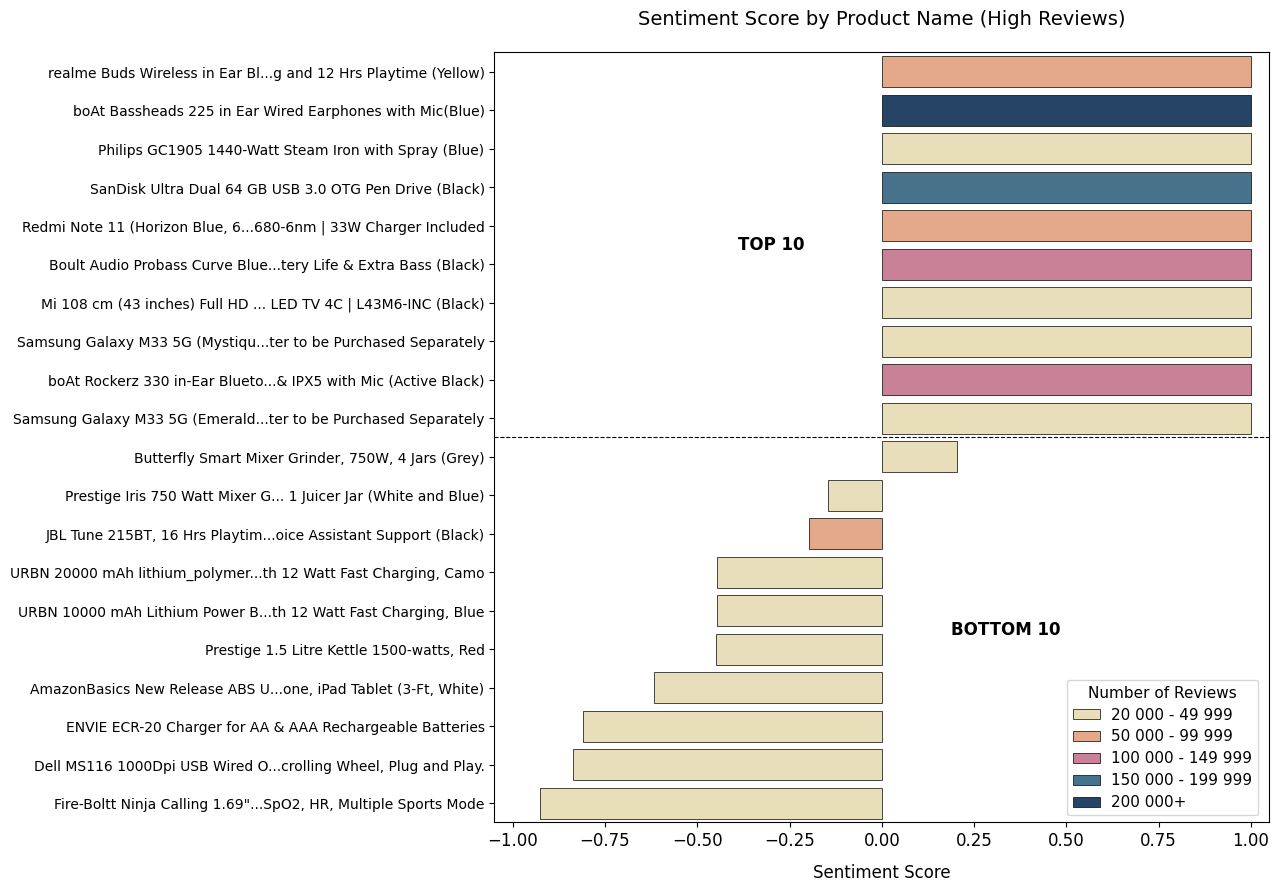

Plot saved to /mnt/c/Users/Joseph/Desktop/quick/0_data/Personal/amazon/fig/product_names_low_reviews.png


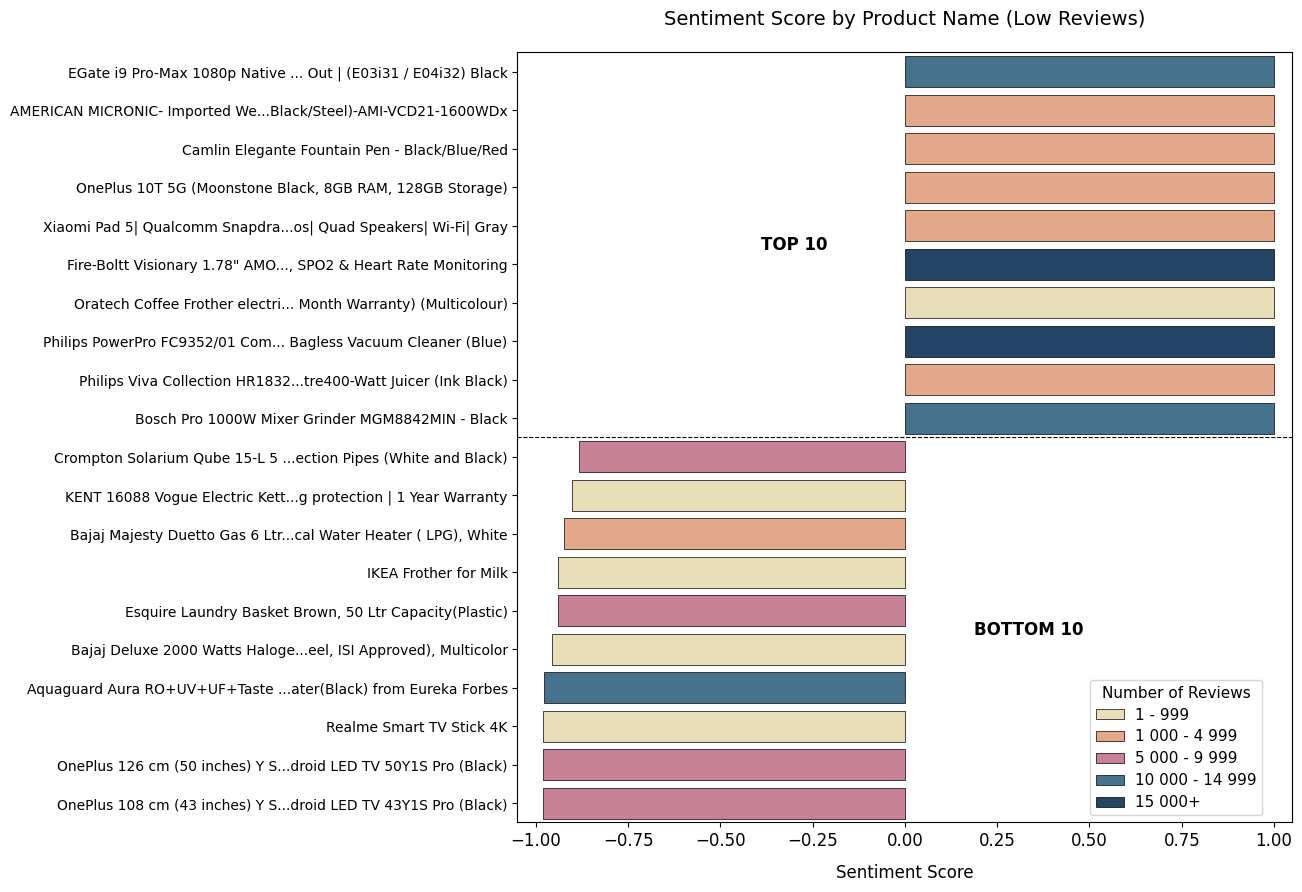

In [24]:
# -------------------------------------------------------------------
# --> 📒[E.4] Sentiment Score by Product name (product_name_trunc) :
# -------------------------------------------------------------------

# --- Categorization Functions ---
def get_rating_count_category_high(val):
    if 20000 <= val < 50000:
        return '20 000 - 49 999'
    elif 50000 <= val < 100000:
        return '50 000 - 99 999'
    elif 100000 <= val < 150000:
        return '100 000 - 149 999'
    elif 150000 <= val < 200000:
        return '150 000 - 199 999'
    else:
        return '200 000+'

def get_rating_count_category_low(val):
    if val < 1000:
        return '1 - 999'
    elif 1000 <= val < 5000:
        return '1 000 - 4 999'
    elif 5000 <= val < 10000:
        return '5 000 - 9 999'
    elif 10000 <= val < 15000:
        return '10 000 - 14 999'
    else:
        return '15 000+'

# --- Data Preparation ---
df_fixed_copy = df_fixed.copy()
df_fixed_copy = df_fixed_copy.sort_values(by='SentimentScore', ascending=False)

high_review_df = df_fixed_copy[df_fixed_copy['rating_count_conv'] >= 20000].copy()
low_review_df = df_fixed_copy[df_fixed_copy['rating_count_conv'] < 20000].copy()

high_review_df['rating_count_category'] = high_review_df['rating_count_conv'].apply(get_rating_count_category_high)
low_review_df['rating_count_category'] = low_review_df['rating_count_conv'].apply(get_rating_count_category_low)

# --- Define Legend Order and Color Mapping ---
high_legend_order = ['20 000 - 49 999', '50 000 - 99 999', '100 000 - 149 999', '150 000 - 199 999', '200 000+']
high_color_mapping = {
    '20 000 - 49 999': '#F0E2B1',  # Cookies And Cream
    '50 000 - 99 999': '#F3A47C',  # Light Salmon
    '100 000 - 149 999': '#D47592', # Charm
    '150 000 - 199 999': '#3B7796', # Jelly Bean Blue
    '200 000+': '#1C436F'           # Rainbow Indigo
}

low_legend_order = ['1 - 999', '1 000 - 4 999', '5 000 - 9 999', '10 000 - 14 999', '15 000+']
low_color_mapping = {
    '1 - 999': '#F0E2B1',          # Cookies And Cream
    '1 000 - 4 999': '#F3A47C',    # Light Salmon
    '5 000 - 9 999': '#D47592',    # Charm
    '10 000 - 14 999': '#3B7796',  # Jelly Bean Blue
    '15 000+': '#1C436F'           # Rainbow Indigo
}

# --- Dictionaries for Label Settings ---
x_setting = {
    "label": "Sentiment Score",
    "fontsize": 12,
    "labelpad": 10,
    "x_min": -1.05,
    "x_max": 1.05,
    "x_ticks": None,
    "xtick_fontsize": 12
}
y_setting = {
    "label": "", 
    "fontsize": 12, 
    "labelpad": 10,
    "ytick_fontsize": 10
}
title_setting = {"title": None, "fontsize": 14, "pad": 20}
legend_setting = {
    "title": "Number of Reviews", 
    "loc": "lower left", 
    "bbox_to_anchor": (0.73, 0),
    "title_fontsize": 11,
    "entry_fontsize": 11
}

# --- Plotting Function ---
def plot_sentiment(df, title, legend_order, color_mapping, 
                   filter_top=None, filter_bot=None,
                   save_file=None, save_directory=None, ann_top_x=None, ann_top_y=None, 
                   ann_bot_x=None, ann_bot_y=None, use_axis_coords=False,
                   x_setting=None, y_setting=None, legend_setting=None, title_setting=None):
    
    if x_setting is None:
        x_setting = {"label": "Sentiment Score", "fontsize": 12, "labelpad": 10,
                     "x_min": None, "x_max": None, "x_ticks": None, "xtick_fontsize": 10}
    if y_setting is None:
        y_setting = {"label": "", "fontsize": 12, "labelpad": 10, "ytick_fontsize": 10}
    if title_setting is None:
        title_setting = {"title": title, "fontsize": 14, "pad": 20}
    else:
        title_setting["title"] = title
    if legend_setting is None:
        legend_setting = {"title": "Number of Reviews", "loc": "lower left", "bbox_to_anchor": (0.75, 0),
                          "title_fontsize": 12, "entry_fontsize": 10}
    
    if filter_top and filter_bot:
        df_top = df.head(filter_top)
        df_bot = df.tail(filter_bot)
        df = pd.concat([df_top, df_bot])
    
    plt.figure(figsize=(10, 10))
    ax = sns.barplot(
        data=df,
        x='SentimentScore',
        y='product_name_trunc',
        hue='rating_count_category',
        hue_order=legend_order,
        palette=color_mapping
    )
    
    for bar in ax.patches:
        bar.set_edgecolor("black")
        bar.set_linewidth(0.5)
    
    if filter_top and filter_bot:
        sep_index = len(df_top) - 0.5
        plt.axhline(y=sep_index, color='black', linestyle='dashed', linewidth=0.8)
        transform = ax.transAxes if use_axis_coords else ax.transData
        ax.text(ann_top_x or 0.4, ann_top_y or 0.75, f"TOP {filter_top}", fontsize=12, fontweight='bold',
                va='center', ha='right', color='black', transform=transform, clip_on=False)
        ax.text(ann_bot_x or 0.73, ann_bot_y or 0.25, f"BOTTOM {filter_bot}", fontsize=12, fontweight='bold',
                va='center', ha='right', color='black', transform=transform, clip_on=False)
    
    if x_setting.get("x_min") is not None or x_setting.get("x_max") is not None:
        plt.xlim(x_setting.get("x_min"), x_setting.get("x_max"))
    if x_setting.get("x_ticks") is not None:
        plt.xticks(x_setting.get("x_ticks"))
    
    plt.xlabel(x_setting.get("label", "Sentiment Score"), fontsize=x_setting.get("fontsize", 12),
               labelpad=x_setting.get("labelpad", 10))
    plt.ylabel(y_setting.get("label", ""), fontsize=y_setting.get("fontsize", 12),
               labelpad=y_setting.get("labelpad", 10))
    plt.title(title_setting.get("title", title), fontsize=title_setting.get("fontsize", 14),
              pad=title_setting.get("pad", 20))
    
    plt.setp(ax.get_xticklabels(), fontsize=x_setting.get("xtick_fontsize", 10))
    plt.setp(ax.get_yticklabels(), fontsize=y_setting.get("ytick_fontsize", 10))
    
    leg = plt.legend(**{k: v for k, v in legend_setting.items() if k not in ["title_fontsize", "entry_fontsize"]})
    if leg.get_title() is not None and "title_fontsize" in legend_setting:
        leg.get_title().set_fontsize(legend_setting["title_fontsize"])
    if "entry_fontsize" in legend_setting:
        for text in leg.get_texts():
            text.set_fontsize(legend_setting["entry_fontsize"])
    
    if save_file:
        if save_directory:
            os.makedirs(save_directory, exist_ok=True)
            filepath = os.path.join(save_directory, save_file)
        else:
            filepath = save_file
        plt.savefig(filepath, bbox_inches='tight')
        print(f"Plot saved to {filepath}")
    
    plt.show()

# --- Plotting the Data ---

# For High Reviews
plot_sentiment(
    high_review_df,
    title="Sentiment Score by Product Name (High Reviews)",
    legend_order=high_legend_order,
    color_mapping=high_color_mapping,
    filter_top=10, filter_bot=10,
    save_file="product_names_high_reviews.png",
    save_directory="/mnt/c/Users/Joseph/Desktop/quick/0_data/Personal/amazon/fig/",
    use_axis_coords=True,
    x_setting=x_setting,
    y_setting=y_setting,
    legend_setting=legend_setting,
    title_setting=title_setting
)

# For Low Reviews
plot_sentiment(
    low_review_df,
    title="Sentiment Score by Product Name (Low Reviews)",
    legend_order=low_legend_order,
    color_mapping=low_color_mapping,
    filter_top=10, filter_bot=10,
    save_file="product_names_low_reviews.png",
    save_directory="/mnt/c/Users/Joseph/Desktop/quick/0_data/Personal/amazon/fig/",
    use_axis_coords=True,
    x_setting=x_setting,
    y_setting=y_setting,
    legend_setting=legend_setting,
    title_setting=title_setting
)

# --- Display Separate HTML Tables for Top and Bottom Rows ---
filter_top_val = 10
filter_bot_val = 10

# Define a mapping dictionary for renaming columns manually
rename_mapping = {
    'product_name': 'Product Name',
    'product_name_trunc': 'Product Name Trunc',
    'SentimentScore': 'Sentiment Score'
}

# High Reviews - Top Table
high_top = high_review_df.head(filter_top_val).reset_index(drop=True)
high_top.insert(0, "No", high_top.index + 1)
high_top = high_top.rename(columns=rename_mapping)
display(HTML("<h2>Product Level | High Reviews - Top Table</h2>"))
display(HTML(high_top[['No', 'Product Name', 'Product Name Trunc', 'Sentiment Score']]
             .to_html(index=False, justify='left')))

# High Reviews - Bottom Table
high_bot = high_review_df.tail(filter_bot_val).reset_index(drop=True)
high_bot.insert(0, "No", high_bot.index + 1)
high_bot = high_bot.rename(columns=rename_mapping)
display(HTML("<h2>Product Level | High Reviews - Bottom Table</h2>"))
display(HTML(high_bot[['No', 'Product Name', 'Product Name Trunc', 'Sentiment Score']]
             .to_html(index=False, justify='left')))

# Low Reviews - Top Table
low_top = low_review_df.head(filter_top_val).reset_index(drop=True)
low_top.insert(0, "No", low_top.index + 1)
low_top = low_top.rename(columns=rename_mapping)
display(HTML("<h2>Product Level | Low Reviews - Top Table</h2>"))
display(HTML(low_top[['No', 'Product Name', 'Product Name Trunc', 'Sentiment Score']]
             .to_html(index=False, justify='left')))

# Low Reviews - Bottom Table
low_bot = low_review_df.tail(filter_bot_val).reset_index(drop=True)
low_bot.insert(0, "No", low_bot.index + 1)
low_bot = low_bot.rename(columns=rename_mapping)
display(HTML("<h2>Product Level | Low Reviews - Bottom Table</h2>"))
display(HTML(low_bot[['No', 'Product Name', 'Product Name Trunc', 'Sentiment Score']]
             .to_html(index=False, justify='left')))

Plot saved to /mnt/c/Users/Joseph/Desktop/quick/0_data/Personal/amazon/fig/rating_count_by_product_sentiment.png


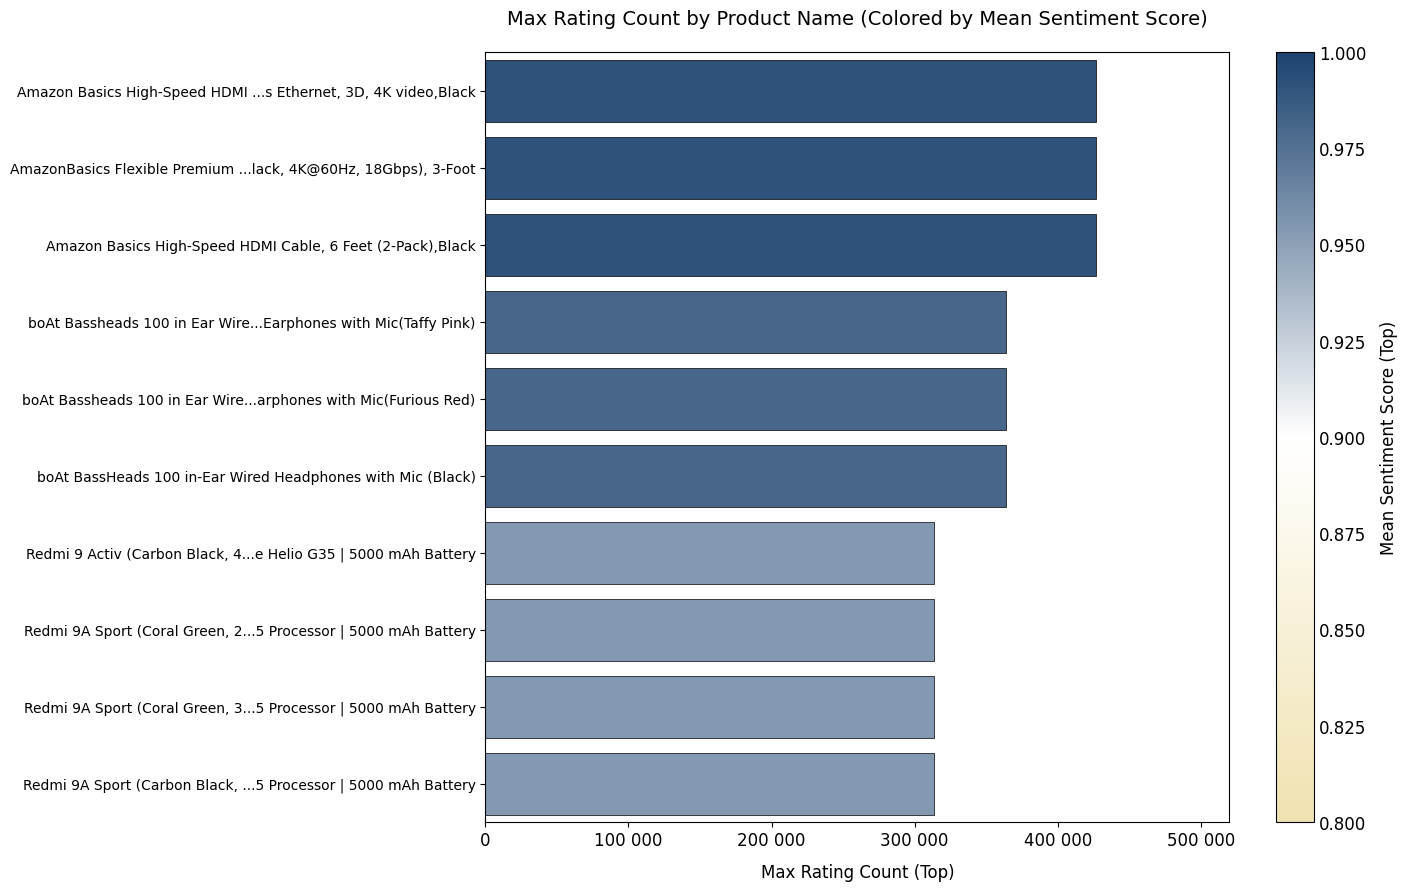

Plot saved to /mnt/c/Users/Joseph/Desktop/quick/0_data/Personal/amazon/fig/rating_count_by_product_sentiment_bottom30.png


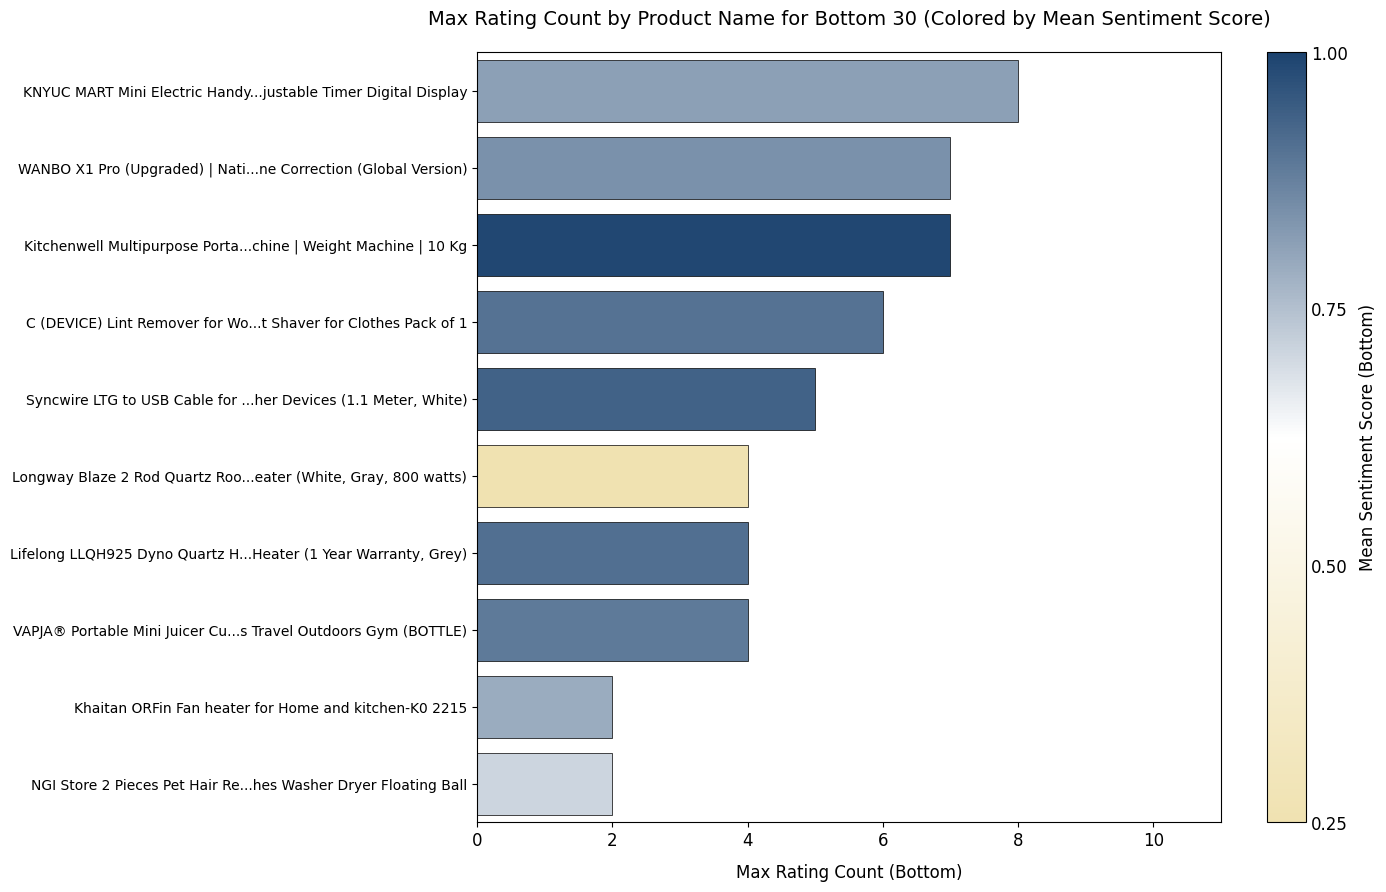

In [25]:
# -------------------------------------------------------------
# --> 📒[E.5] Popularity (rating_count_conv) by Product name :
# -------------------------------------------------------------

# --- Dictionary Settings for Top Plot ---
x_setting_top = {
    "label": "Max Rating Count (Top)",
    "fontsize": 12,
    "labelpad": 10,
    "x_min": None,       # e.g., set to 0 if desired
    "x_max": 520000,     
    "x_ticks": [0, 100000, 200000, 300000, 400000, 500000],
    "x_tick_labels": ["0", "100 000", "200 000", "300 000", "400 000", "500 000"],
    "xtick_fontsize": 12
}
y_setting_top = {
    "label": "", 
    "fontsize": 12, 
    "labelpad": 10,
    "ytick_fontsize": 10
}
title_setting_top = {
    "title": None,  # This will be updated per plot call
    "fontsize": 14,
    "pad": 20
}
legend_setting_top = {
    "title": "Mean Sentiment Score (Top)", 
    "title_fontsize": 12,
    "title_pad": 10,                
    "legend_tick_fontsize": 12,
    "legend_min": 0.8,            # Force the colorbar minimum
    "legend_max": 1,              # Force the colorbar maximum
    "legend_ticks": [0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95, 0.975, 1],
    "loc": "upper left", 
    "bbox_to_anchor": (1, 1)
}

# --- Dictionary Settings for Bottom Plot ---
x_setting_bottom = {
    "label": "Max Rating Count (Bottom)",
    "fontsize": 12,
    "labelpad": 10,
    "x_min": None,       
    "x_max": 11,       
    "x_ticks": [0,2,4,6,8,10],     
    "xtick_fontsize": 12
}
y_setting_bottom = {
    "label": "", 
    "fontsize": 12, 
    "labelpad": 10,
    "ytick_fontsize": 10
}
title_setting_bottom = {
    "title": None,  
    "fontsize": 14,
    "pad": 20
}
legend_setting_bottom = {
    "title": "Mean Sentiment Score (Bottom)", 
    "title_fontsize": 12,
    "title_pad": 8,                
    "legend_tick_fontsize": 12,
    "legend_min": 0.25,            
    "legend_max": 1,             
    "legend_ticks": [0.25, 0.5, 0.75, 1],
    "loc": "upper left", 
    "bbox_to_anchor": (1, 1)
}

# --- Data Preparation ---


df_fixed_copy = df_fixed.copy()

df_fixed_copy = df_fixed_copy.sort_values(by='rating_count_conv', ascending=False)

# --- Plotting Function for Top 30 ---
def plot_rating_count(df, title, filter_top=30, save_file=None, save_directory=None,
                      x_setting=None, y_setting=None, title_setting=None, legend_setting=None):
    df = df.head(filter_top)  # Select only the top N products

    plt.figure(figsize=(12, 10))
    ax = sns.barplot(
        data=df,
        x='rating_count_conv',
        y='product_name_trunc'
    )
    
    custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["#F0E2B1", "white", "#1C436F"])
    if legend_setting and legend_setting.get("legend_min") is not None and legend_setting.get("legend_max") is not None:
        vmin = legend_setting["legend_min"]
        vmax = legend_setting["legend_max"]
    else:
        vmin = df['SentimentScore'].min()
        vmax = df['SentimentScore'].max()
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
    sm.set_array([])

    # Set bar colors and add a 0.5-width black outline
    for bar, sentiment in zip(ax.patches, df['SentimentScore']):
        bar.set_color(custom_cmap(norm(sentiment)))
        bar.set_edgecolor("black")
        bar.set_linewidth(0.5)
    
    # Apply x-axis settings
    if x_setting:
        if x_setting.get("x_min") is not None or x_setting.get("x_max") is not None:
            plt.xlim(x_setting.get("x_min"), x_setting.get("x_max"))
        if x_setting.get("x_ticks") is not None:
            if "x_tick_labels" in x_setting:
                plt.xticks(x_setting.get("x_ticks"), x_setting.get("x_tick_labels"))
            else:
                plt.xticks(x_setting.get("x_ticks"))
        plt.setp(ax.get_xticklabels(), fontsize=x_setting.get("xtick_fontsize", 10))
    if y_setting:
        plt.setp(ax.get_yticklabels(), fontsize=y_setting.get("ytick_fontsize", 10))
    
    # Set labels and title using provided settings
    plt.xlabel(x_setting.get("label", "Max Rating Count") if x_setting else "Max Rating Count",
               fontsize=x_setting.get("fontsize", 12) if x_setting else 12,
               labelpad=x_setting.get("labelpad", 10) if x_setting else 10)
    plt.ylabel(y_setting.get("label", "") if y_setting else "",
               fontsize=y_setting.get("fontsize", 12) if y_setting else 12,
               labelpad=y_setting.get("labelpad", 10) if y_setting else 10)
    if title_setting:
        title_setting["title"] = title
    else:
        title_setting = {"title": title, "fontsize": 14, "pad": 20}
    plt.title(title_setting.get("title", title), fontsize=title_setting.get("fontsize", 14),
              pad=title_setting.get("pad", 20))
    
    # Create a colorbar and update settings using legend_setting
    cbar = plt.colorbar(sm, ax=ax)
    if legend_setting:
        if legend_setting.get("legend_ticks") is not None:
            cbar.set_ticks(legend_setting["legend_ticks"])
    cbar.set_label(legend_setting.get("title", "Mean Sentiment Score") if legend_setting else "Mean Sentiment Score",
                   fontsize=legend_setting.get("title_fontsize", 12) if legend_setting else 12,
                   labelpad=legend_setting.get("title_pad", 5) if legend_setting else 5)
    # Remove tick marks from the colorbar by setting their length to 0
    cbar.ax.tick_params(labelsize=legend_setting.get("legend_tick_fontsize", 10) if legend_setting else 10, length=0)
    
    if save_file:
        if save_directory:
            os.makedirs(save_directory, exist_ok=True)
            filepath = os.path.join(save_directory, save_file)
        else:
            filepath = save_file
        plt.savefig(filepath, bbox_inches='tight')
        print(f"Plot saved to {filepath}")
    
    plt.show()

# --- Plotting Function for Bottom 30 ---
def plot_rating_count_bottom(df, title, filter_bottom=30, save_file=None, save_directory=None,
                             x_setting=None, y_setting=None, title_setting=None, legend_setting=None):
    df = df.tail(filter_bottom)  # Select only the bottom N products
    
    plt.figure(figsize=(12, 10))
    ax = sns.barplot(
        data=df,
        x='rating_count_conv',
        y='product_name_trunc'
    )
    
    custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["#F0E2B1", "white", "#1C436F"])
    if legend_setting and legend_setting.get("legend_min") is not None and legend_setting.get("legend_max") is not None:
        vmin = legend_setting["legend_min"]
        vmax = legend_setting["legend_max"]
    else:
        vmin = df['SentimentScore'].min()
        vmax = df['SentimentScore'].max()
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
    sm.set_array([])

    # Set bar colors and add a 0.5-width black outline
    for bar, sentiment in zip(ax.patches, df['SentimentScore']):
        bar.set_color(custom_cmap(norm(sentiment)))
        bar.set_edgecolor("black")
        bar.set_linewidth(0.5)
    
    # Apply x-axis settings
    if x_setting:
        if x_setting.get("x_min") is not None or x_setting.get("x_max") is not None:
            plt.xlim(x_setting.get("x_min"), x_setting.get("x_max"))
        if x_setting.get("x_ticks") is not None:
            plt.xticks(x_setting.get("x_ticks"))
        plt.setp(ax.get_xticklabels(), fontsize=x_setting.get("xtick_fontsize", 10))
    if y_setting:
        plt.setp(ax.get_yticklabels(), fontsize=y_setting.get("ytick_fontsize", 10))
    
    # Set labels and title using provided settings
    plt.xlabel(x_setting.get("label", "Max Rating Count") if x_setting else "Max Rating Count",
               fontsize=x_setting.get("fontsize", 12) if x_setting else 12,
               labelpad=x_setting.get("labelpad", 10) if x_setting else 10)
    plt.ylabel(y_setting.get("label", "") if y_setting else "",
               fontsize=y_setting.get("fontsize", 12) if y_setting else 12,
               labelpad=y_setting.get("labelpad", 10) if y_setting else 10)
    if title_setting:
        title_setting["title"] = title
    else:
        title_setting = {"title": title, "fontsize": 14, "pad": 20}
    plt.title(title_setting.get("title", title), fontsize=title_setting.get("fontsize", 14),
              pad=title_setting.get("pad", 20))
    
    # Create a colorbar and update settings using legend_setting
    cbar = plt.colorbar(sm, ax=ax)
    if legend_setting:
        if legend_setting.get("legend_ticks") is not None:
            cbar.set_ticks(legend_setting["legend_ticks"])
    cbar.set_label(legend_setting.get("title", "Mean Sentiment Score") if legend_setting else "Mean Sentiment Score",
                   fontsize=legend_setting.get("title_fontsize", 12) if legend_setting else 12,
                   labelpad=legend_setting.get("title_pad", 5) if legend_setting else 5)
    cbar.ax.tick_params(labelsize=legend_setting.get("legend_tick_fontsize", 10) if legend_setting else 10, length=0)
    
    if save_file:
        if save_directory:
            os.makedirs(save_directory, exist_ok=True)
            filepath = os.path.join(save_directory, save_file)
        else:
            filepath = save_file
        plt.savefig(filepath, bbox_inches='tight')
        print(f"Plot saved to {filepath}")
    
    plt.show()

# --- Generate the Figures ---
# Top 30 products figure
plot_rating_count(
    df_fixed_copy,
    title="Max Rating Count by Product Name (Colored by Mean Sentiment Score)",
    filter_top=10,
    save_file="rating_count_by_product_sentiment.png",
    save_directory="/mnt/c/Users/Joseph/Desktop/quick/0_data/Personal/amazon/fig/",
    x_setting=x_setting_top,
    y_setting=y_setting_top,
    title_setting=title_setting_top,
    legend_setting=legend_setting_top
)

# Bottom 30 products figure
plot_rating_count_bottom(
    df_fixed_copy,
    title="Max Rating Count by Product Name for Bottom 30 (Colored by Mean Sentiment Score)",
    filter_bottom=10,
    save_file="rating_count_by_product_sentiment_bottom30.png",
    save_directory="/mnt/c/Users/Joseph/Desktop/quick/0_data/Personal/amazon/fig/",
    x_setting=x_setting_bottom,
    y_setting=y_setting_bottom,
    title_setting=title_setting_bottom,
    legend_setting=legend_setting_bottom
)

# --- Generate the Tables ---

# Define the columns to display
columns_to_show = ["product_name", "product_name_trunc", "rating_count_conv", "SentimentScore"]

# Filter the top 10 rows (based on the sort order)
top_filtered = df_fixed_copy.head(10)
# Filter the bottom 10 rows
bottom_filtered = df_fixed_copy.tail(10)

# Display the top table with a header
display(HTML("<h2>Top 10 Products</h2>" + top_filtered[columns_to_show].to_html(index=False)))

# Display the bottom table with a header
display(HTML("<h2>Bottom 10 Products</h2>" + bottom_filtered[columns_to_show].to_html(index=False)))


Plot saved to /mnt/c/Users/Joseph/Desktop/quick/0_data/Personal/amazon/fig/pearson_correlation_matrix.png


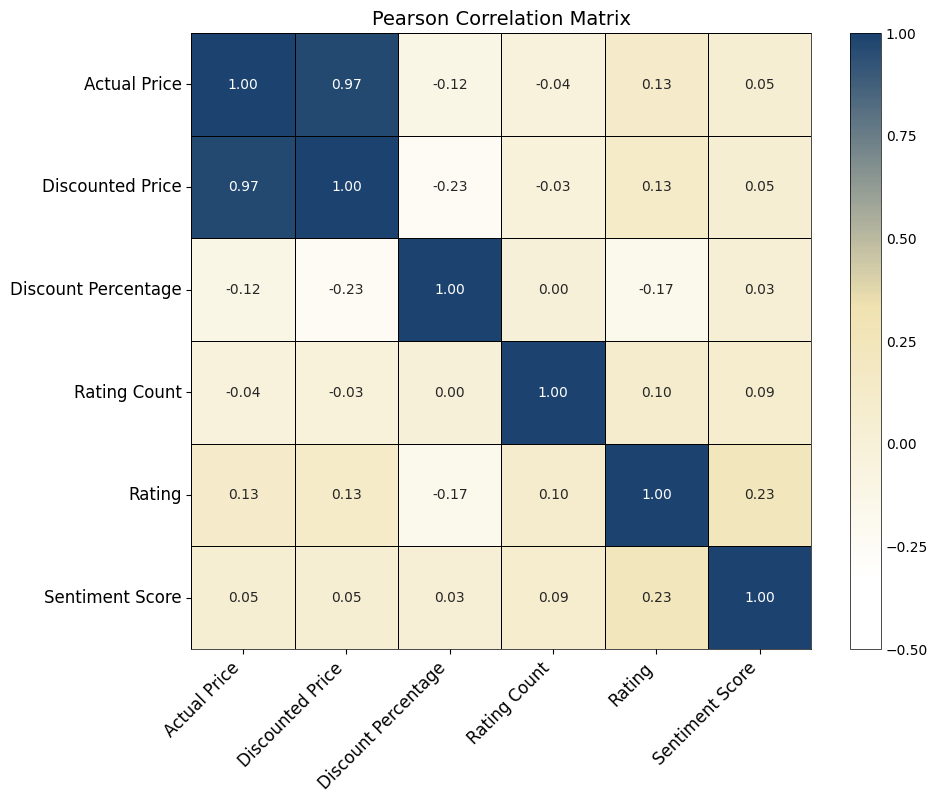

In [26]:
# --------------------------------------------------------------------
# --> 📒[E.5] Relationship of Semantic Score on Numerical Variables :
# --------------------------------------------------------------------

# --- New Column Order and Display Labels ---
cols = ['actual_price_conv', 'discounted_price_conv', 'discount_percentage_conv', 'rating_count_conv', 'rating', 'SentimentScore']
display_labels = ['Actual Price', 'Discounted Price', 'Discount Percentage', 'Rating Count', 'Rating', 'Sentiment Score']

# --- Legend Settings for the Heatmap (Colorbar) ---
legend_setting = {
    "legend_min": -0.5,                       # Force the colorbar minimum
    "legend_max": 1,                          # Force the colorbar maximum
    "legend_ticks": [-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1]  # Custom tick values for the colorbar
}

# --- Data Preparation ---

# Initialize empty DataFrames to store correlation coefficients and p-values.
corr_matrix = pd.DataFrame(np.zeros((len(cols), len(cols))), index=display_labels, columns=display_labels)
p_matrix = pd.DataFrame(np.zeros((len(cols), len(cols))), index=display_labels, columns=display_labels)

# Compute Pearson correlation coefficient and p-value for each pair of columns.
for i in range(len(cols)):
    for j in range(len(cols)):
        r, p = pearsonr(df_fixed[cols[i]].dropna(), df_fixed[cols[j]].dropna())  # Drop NaN values
        corr_matrix.iloc[i, j] = r
        p_matrix.iloc[i, j] = p

# Define a custom colormap from white to light yellow to deep indigo
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["white", "white", "#F0E2B1", "#1C436F"])

# --- Create the Heatmap ---
plt.figure(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap=custom_cmap, center=0, 
                 linewidths=0.5, linecolor='black', cbar=True,
                 vmin=legend_setting["legend_min"],
                 vmax=legend_setting["legend_max"],
                 cbar_kws={'ticks': legend_setting["legend_ticks"]})

# Outline the entire plot (axes border)
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_color("black")
    spine.set_linewidth(0.5)

# Outline the colorbar and remove its tick marks
cbar = ax.collections[0].colorbar
cbar.outline.set_edgecolor("black")
cbar.outline.set_linewidth(0.5)
cbar.ax.tick_params(length=0)  # Remove tick bars on the colorbar

# Set axis tick labels and fonts
ax.set_xticklabels(display_labels, rotation=45, ha="right", fontsize=12)
ax.set_yticklabels(display_labels, rotation=0, fontsize=12)

plt.title("Pearson Correlation Matrix", fontsize=14)

# --- Saving the Plot ---
save_file = "pearson_correlation_matrix.png"    # Set your desired filename here
save_directory = "/mnt/c/Users/Joseph/Desktop/quick/0_data/Personal/amazon/fig/"  # Set your desired directory here
if save_file:
    if save_directory:
        os.makedirs(save_directory, exist_ok=True)
        filepath = os.path.join(save_directory, save_file)
    else:
        filepath = save_file
    plt.savefig(filepath, bbox_inches='tight')
    print(f"Plot saved to {filepath}")

plt.show()


/tmp/ipykernel_1775/4195406213.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
/tmp/ipykernel_1775/4195406213.py:80: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, fontsize=12)


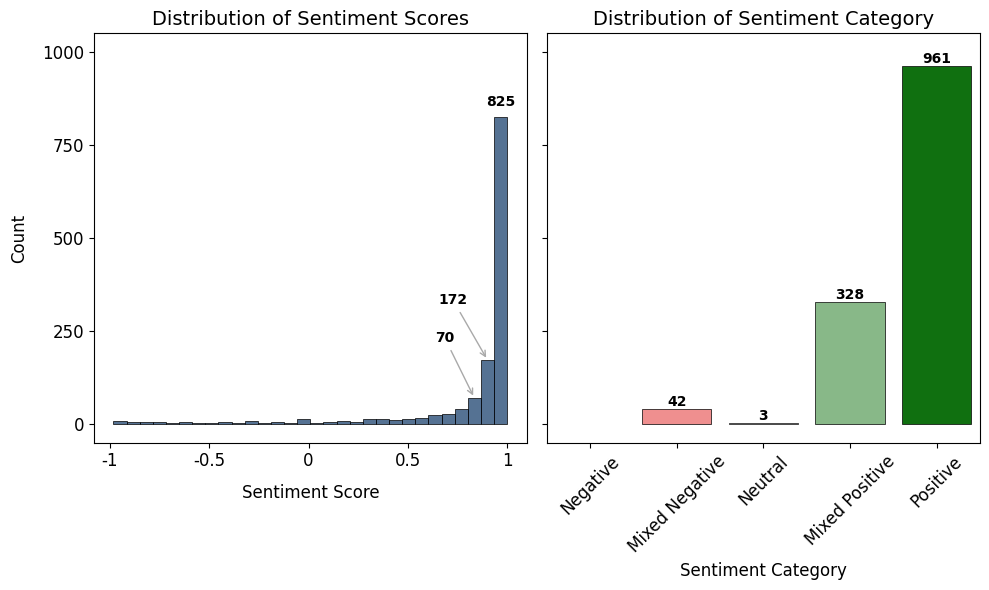

Figure saved to: /mnt/c/Users/Joseph/Desktop/quick/0_data/Personal/amazon/fig/merged_sentiment_plots.png


In [30]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Assume df_fixed is your preprocessed DataFrame
# Define ordering for sentiment categories and buckets
sentiment_order = ['Negative', 'Mixed Negative', 'Neutral', 'Mixed Positive', 'Positive']
bucket_order = ['-1.0 to -0.5', '-0.49 to 0.0', '0.0 to 0.49', '0.5 to 1.0']

df_fixed['SentimentCategory'] = pd.Categorical(df_fixed['SentimentCategory'], categories=sentiment_order, ordered=True)
df_fixed['SentimentBucket'] = pd.Categorical(df_fixed['SentimentBucket'], categories=bucket_order, ordered=True)

# Create the custom red-white-green colormap for the sentiment category plot
custom_cmap = LinearSegmentedColormap.from_list("custom_rwg", ["red", "white", "green"], N=len(sentiment_order))
custom_palette = [custom_cmap(i / (len(sentiment_order) - 1)) for i in range(len(sentiment_order))]

# Create a figure with two subplots (side by side) that share the y-axis
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 6))

# ---------------------------------------------------------------------------
# Subplot 1 (Left): Sentiment Score Histogram
# ---------------------------------------------------------------------------
sns.histplot(
    df_fixed['SentimentScore'],
    bins=30,
    color="#1C436F",
    edgecolor="black",
    linewidth=0.5,
    ax=ax[0]
)

ax[0].set_xlabel("Sentiment Score", fontsize=12, labelpad=10)
ax[0].set_ylabel("Count", fontsize=12, labelpad=10)
ax[0].set_title("Distribution of Sentiment Scores", fontsize=14)
ax[0].set_xticks([-1, -0.5, 0, 0.5, 1])
ax[0].set_xticklabels([-1, -0.5, 0, 0.5, 1], fontsize=12)
ax[0].set_yticks([0, 250, 500, 750, 1000])
ax[0].set_yticklabels([0, 250, 500, 750, 1000], fontsize=12)
ax[0].set_ylim(-50, 950)

# Compute histogram data to annotate top bins
counts, bins = np.histogram(df_fixed['SentimentScore'], bins=30)
bin_centers = (bins[:-1] + bins[1:]) / 2
top_three_indices = np.argsort(counts)[-3:][::-1]  # Top three bins (descending)
top_counts = counts[top_three_indices]
top_centers = bin_centers[top_three_indices]

# Annotate the highest bin (simple text)
ax[0].text(top_centers[0], top_counts[0] + 30, f'{top_counts[0]}',
           ha='center', fontsize=10, fontweight='bold')

# Annotate second and third highest bins with slanted arrows to the left
for center, count in zip(top_centers[1:], top_counts[1:]):
    ax[0].annotate(
        f"{count}",
        xy=(center, count),
        xytext=(center - 0.1, count + 150),
        ha='right', fontsize=10, fontweight='bold',
        arrowprops=dict(edgecolor='#A9A9A9', arrowstyle="->", linewidth=1)
    )

# ---------------------------------------------------------------------------
# Subplot 2 (Right): Sentiment Category Count Plot
# ---------------------------------------------------------------------------
sns.countplot(
    x='SentimentCategory',
    data=df_fixed,
    palette=custom_palette,
    order=sentiment_order,
    edgecolor="black",
    linewidth=0.5,
    ax=ax[1]
)

ax[1].set_xlabel("Sentiment Category", fontsize=12)
ax[1].set_title("Distribution of Sentiment Category", fontsize=14)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, fontsize=12)
ax[1].set_ylim(-50, 1050)
# Remove y-axis labels and ticks for the right subplot since they are shared
ax[1].set_ylabel("")
ax[1].tick_params(labelleft=False)

# Annotate each bar with its count
for p in ax[1].patches:
    ax[1].annotate(
        f'{int(p.get_height())}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='bottom', fontsize=10, fontweight='bold'
    )

# Adjust layout for better spacing
plt.tight_layout()

# Define directory and filename for saving the merged figure
save_dir = "/mnt/c/Users/Joseph/Desktop/quick/0_data/Personal/amazon/fig"
os.makedirs(save_dir, exist_ok=True)
file_name = "merged_sentiment_plots.png"
save_path = os.path.join(save_dir, file_name)

# Save the figure
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Figure saved to: {save_path}")
